In [3]:
import pandas as pd
import numpy as np
import os
from scipy.io import loadmat

In [4]:
# Load the CSV file
quality_df = pd.read_csv('Data_Quality_Evaluation.csv', index_col=0)

# Transpose the DataFrame
quality_df = quality_df.T


In [5]:
quality_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,2,1,1,4,1,5,3,5,1,5,...,5,1,1,5,3,4,1,1,5,1
2,1,4,5,1,1,5,1,1,1,1,...,3,1,1,3,1,1,1,2,1,2
3,1,1,1,1,1,1,1,1,3,1,...,1,4,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,5
5,5,5,4,3,3,4,4,4,5,4,...,4,3,4,3,3,3,3,3,5,4


In [6]:
# Define EEG channels
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Function to extract all channels from a .mat file
def get_all_channels_from_mat(file_path):
    """
    Load a .mat file and extract all channels as a NumPy array.
    Returns a 8xTime NumPy array where each row is a channel.
    Returns None if file doesn't exist or has issues.
    """
    try:
        mat_data = loadmat(file_path)
        
        # Use 'ThisEEG' as the data key
        data_key = 'ThisEEG'
        
        if data_key not in mat_data:
            print(f"Warning: 'ThisEEG' key not found in {file_path}")
            return None
        
        # Assume the data is already in 8xTime format
        data_array = mat_data[data_key]
        
        # Return as NumPy array with shape (8, time_points)
        return np.array(data_array, dtype=np.float64)
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


In [7]:
# Build the main DataFrame
# Participants: 1 to 58 (as strings to match quality_df)
# Video clips: 1 to 36

participants = [str(i) for i in range(1, 59)]  # "1" to "58" as strings
video_clips = list(range(1, 37))  # 1 to 36

# Initialize DataFrame with object dtype to store NumPy arrays
eeg_df = pd.DataFrame(index=participants, columns=video_clips, dtype=object)

# Fill the DataFrame
for participant in participants:
    # Convert participant string to P01 format for folder name
    participant_folder = f"P{int(participant):02d}"
    
    for video_id in video_clips:
        file_path = f'EEGData/Movie_{participant_folder}/EEG_Clip{video_id}.mat'
        
        # Get all channels as a NumPy array (8xTime)
        eeg_array = get_all_channels_from_mat(file_path)
        
        if eeg_array is not None:
            eeg_df.at[participant, video_id] = eeg_array
        else:
            eeg_df.at[participant, video_id] = None
    
eeg_df.shape

(58, 36)

In [8]:
eeg_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[[336.0, 234.5, 133.0, 133.0, 133.0, 133.0, 13...","[[435.0, 435.0, 372.0, 309.0, 309.0, 357.0, 40...","[[325.0, 325.0, 328.5, 332.0, 332.0, 332.0, 35...","[[374.0, 374.0, 374.0, 413.5, 453.0, 453.0, 45...","[[264.0, 260.0, 256.0, 256.0, 307.0, 358.0, 35...","[[272.5, 268.0, 268.0, 290.0, 312.0, 312.0, 31...","[[345.5, 314.0, 314.0, 323.0, 332.0, 332.0, 34...","[[385.0, 385.0, 333.5, 282.0, 282.0, 326.5, 37...","[[289.0, 289.0, 281.5, 274.0, 274.0, 274.0, 27...","[[470.0, 470.0, 381.0, 292.0, 292.0, 355.0, 41...",...,"[[89.0, 89.0, 89.0, 89.0, 89.0, 89.0, 188.5, 2...","[[305.0, 306.5, 308.0, 308.0, 272.5, 237.0, 23...","[[320.5, 315.0, 315.0, 315.0, 303.5, 292.0, 29...","[[277.0, 278.0, 279.0, 289.0, 299.0, 299.0, 29...","[[528.0, 528.0, 404.0, 280.0, 280.0, 261.0, 24...","[[135.0, 135.0, 161.5, 188.0, 188.0, 218.0, 24...","[[401.0, 401.0, 369.0, 337.0, 337.0, 364.5, 39...","[[329.0, 329.0, 329.0, 329.0, 329.0, 354.0, 37...","[[213.0, 276.5, 340.0, 340.0, 365.0, 390.0, 39...","[[458.0, 458.0, 458.0, 369.5, 281.0, 281.0, 33..."
2,"[[410.0, 381.5, 353.0, 353.0, 318.5, 284.0, 28...","[[257.0, 257.0, 257.0, 257.0, 257.0, 318.0, 37...","[[259.0, 343.5, 428.0, 428.0, 398.5, 369.0, 36...","[[497.0, 337.0, 337.0, 337.0, 333.0, 329.0, 32...","[[389.0, 389.0, 389.0, 352.0, 315.0, 315.0, 27...","[[295.0, 295.0, 305.5, 316.0, 316.0, 324.0, 33...","[[170.5, 341.0, 341.0, 379.0, 417.0, 417.0, 41...","[[628.0, 628.0, 628.0, 628.0, 637.0, 646.0, 64...","[[603.0, 392.0, 181.0, 181.0, 208.5, 236.0, 23...","[[700.0, 700.0, 700.0, 0.0, 0.0, 0.0, 117.0, 1...",...,"[[120.0, 206.5, 293.0, 293.0, 293.0, 299.5, 30...","[[749.0, 749.0, 624.0, 499.0, 499.0, 476.5, 45...","[[88.0, 88.0, 223.0, 358.0, 358.0, 357.5, 357....","[[314.0, 314.0, 519.5, 725.0, 725.0, 401.5, 78...","[[342.0, 348.0, 354.0, 354.0, 340.0, 326.0, 32...","[[217.0, 217.0, 256.0, 295.0, 295.0, 295.0, 32...","[[240.0, 322.0, 322.0, 462.5, 603.0, 603.0, 30...","[[116.5, 194.0, 194.0, 173.5, 153.0, 153.0, 21...","[[626.0, 631.5, 637.0, 637.0, 637.0, 476.0, 31...","[[362.0, 362.0, 362.0, 362.0, 362.0, 362.0, 36..."
3,"[[338.0, 356.0, 374.0, 374.0, 331.0, 288.0, 28...","[[300.0, 300.0, 328.5, 357.0, 357.0, 357.0, 34...","[[376.0, 360.0, 360.0, 322.0, 284.0, 284.0, 22...","[[0.0, 0.0, 105.0, 210.0, 210.0, 349.0, 488.0,...","[[321.0, 321.0, 321.0, 321.0, 321.0, 309.5, 29...","[[132.0, 132.0, 150.0, 168.0, 168.0, 175.5, 18...","[[344.5, 361.0, 361.0, 350.0, 339.0, 339.0, 34...","[[327.5, 360.0, 360.0, 345.5, 331.0, 331.0, 32...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[358.0, 314.0, 314.0, 302.0, 290.0, 290.0, 30...",...,"[[254.0, 254.0, 263.0, 272.0, 272.0, 262.5, 25...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[315.0, 315.0, 314.5, 314.0, 314.0, 314.0, 29...","[[348.5, 348.0, 348.0, 331.5, 315.0, 315.0, 31...","[[465.0, 352.0, 352.0, 267.0, 182.0, 182.0, 18...","[[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 24...","[[421.0, 366.0, 311.0, 311.0, 295.5, 280.0, 28...","[[292.0, 232.5, 173.0, 173.0, 284.5, 396.0, 39...","[[323.0, 323.0, 161.5, 0.0, 0.0, 0.0, 0.0, 0.0...","[[459.0, 459.0, 459.0, 459.0, 433.5, 408.0, 40..."
4,"[[419.0, 663.5, 908.0, 908.0, 908.0, 646.5, 38...","[[267.0, 343.5, 420.0, 420.0, 210.0, 0.0, 0.0,...","[[408.0, 376.0, 344.0, 344.0, 262.0, 180.0, 18...","[[333.0, 226.0, 226.0, 226.0, 303.5, 381.0, 38...","[[320.0, 320.0, 340.0, 360.0, 360.0, 679.5, 99...","[[456.0, 415.5, 375.0, 320.0, 265.0, 265.0, 26...","[[296.0, 296.0, 409.5, 523.0, 523.0, 523.0, 76...","[[357.0, 374.0, 374.0, 366.0, 358.0, 358.0, 42...","[[358.0, 528.0, 528.0, 528.0, 237.0, 237.0, 23...","[[182.0, 9.0, 9.0, 80.0, 151.0, 151.0, 304.5, ...",...,"[[150.0, 150.0, 125.0, 100.0, 100.0, 132.5, 16...","[[283.0, 283.0, 303.5, 324.0, 324.0, 362.0, 40...","[[352.0, 340.0, 328.0, 328.0, 385.5, 443.0, 44...","[[111.0, 111.0, 111.0, 164.0, 164.0, 164.0, 16...","[[421.0, 343.0, 265.0, 265.0, 410.5, 556.0, 55...","[[148.0, 148.0, 185

In [9]:
# Create cleaned DataFrame based on quality scores
# 1 = perfect, 2 = good, 3 = ok, 4 = problematic, 5 = bad, 6 = missing
# Remove all data with quality score => 3

# Start with a copy of eeg_df
eeg_cleaned_df = eeg_df.copy()

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        # Check if quality score exists and is > 3
        if participant in quality_df.index and video_id in quality_df.columns:
            quality_score = quality_df.loc[participant, video_id]
            if pd.notna(quality_score) and quality_score > 3:
                # Set the corresponding EEG data to None
                eeg_cleaned_df.at[participant, video_id] = None


print(f"Original non-null cells: {eeg_df.notna().sum().sum()}")
print(f"Cleaned non-null cells: {eeg_cleaned_df.notna().sum().sum()}")
print(f"Cells removed: {eeg_df.notna().sum().sum() - eeg_cleaned_df.notna().sum().sum()}")


Original non-null cells: 2088
Cleaned non-null cells: 1623
Cells removed: 465


In [10]:
eeg_cleaned_df.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[[336.0, 234.5, 133.0, 133.0, 133.0, 133.0, 13...","[[435.0, 435.0, 372.0, 309.0, 309.0, 357.0, 40...","[[325.0, 325.0, 328.5, 332.0, 332.0, 332.0, 35...",None,"[[264.0, 260.0, 256.0, 256.0, 307.0, 358.0, 35...",None,"[[345.5, 314.0, 314.0, 323.0, 332.0, 332.0, 34...",None,"[[289.0, 289.0, 281.5, 274.0, 274.0, 274.0, 27...",None,...,None,"[[305.0, 306.5, 308.0, 308.0, 272.5, 237.0, 23...","[[320.5, 315.0, 315.0, 315.0, 303.5, 292.0, 29...",None,"[[528.0, 528.0, 404.0, 280.0, 280.0, 261.0, 24...",None,"[[401.0, 401.0, 369.0, 337.0, 337.0, 364.5, 39...","[[329.0, 329.0, 329.0, 329.0, 329.0, 354.0, 37...",None,"[[458.0, 458.0, 458.0, 369.5, 281.0, 281.0, 33..."
2,"[[410.0, 381.5, 353.0, 353.0, 318.5, 284.0, 28...",None,None,"[[497.0, 337.0, 337.0, 337.0, 333.0, 329.0, 32...","[[389.0, 389.0, 389.0, 352.0, 315.0, 315.0, 27...",None,"[[170.5, 341.0, 341.0, 379.0, 417.0, 417.0, 41...","[[628.0, 628.0, 628.0, 628.0, 637.0, 646.0, 64...","[[603.0, 392.0, 181.0, 181.0, 208.5, 236.0, 23...","[[700.0, 700.0, 700.0, 0.0, 0.0, 0.0, 117.0, 1...",...,"[[120.0, 206.5, 293.0, 293.0, 293.0, 299.5, 30...","[[749.0, 749.0, 624.0, 499.0, 499.0, 476.5, 45...","[[88.0, 88.0, 223.0, 358.0, 358.0, 357.5, 357....","[[314.0, 314.0, 519.5, 725.0, 725.0, 401.5, 78...","[[342.0, 348.0, 354.0, 354.0, 340.0, 326.0, 32...","[[217.0, 217.0, 256.0, 295.0, 295.0, 295.0, 32...","[[240.0, 322.0, 322.0, 462.5, 603.0, 603.0, 30...","[[116.5, 194.0, 194.0, 173.5, 153.0, 153.0, 21...","[[626.0, 631.5, 637.0, 637.0, 637.0, 476.0, 31...","[[362.0, 362.0, 362.0, 362.0, 362.0, 362.0, 36..."
3,"[[338.0, 356.0, 374.0, 374.0, 331.0, 288.0, 28...","[[300.0, 300.0, 328.5, 357.0, 357.0, 357.0, 34...","[[376.0, 360.0, 360.0, 322.0, 284.0, 284.0, 22...","[[0.0, 0.0, 105.0, 210.0, 210.0, 349.0, 488.0,...","[[321.0, 321.0, 321.0, 321.0, 321.0, 309.5, 29...","[[132.0, 132.0, 150.0, 168.0, 168.0, 175.5, 18...","[[344.5, 361.0, 361.0, 350.0, 339.0, 339.0, 34...","[[327.5, 360.0, 360.0, 345.5, 331.0, 331.0, 32...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[358.0, 314.0, 314.0, 302.0, 290.0, 290.0, 30...",...,"[[254.0, 254.0, 263.0, 272.0, 272.0, 262.5, 25...",None,"[[315.0, 315.0, 314.5, 314.0, 314.0, 314.0, 29...","[[348.5, 348.0, 348.0, 331.5, 315.0, 315.0, 31...","[[465.0, 352.0, 352.0, 267.0, 182.0, 182.0, 18...","[[244.0, 244.0, 244.0, 244.0, 244.0, 244.0, 24...","[[421.0, 366.0, 311.0, 311.0, 295.5, 280.0, 28...","[[292.0, 232.5, 173.0, 173.0, 284.5, 396.0, 39...","[[323.0, 323.0, 161.5, 0.0, 0.0, 0.0, 0.0, 0.0...","[[459.0, 459.0, 459.0, 459.0, 433.5, 408.0, 40..."
4,"[[419.0, 663.5, 908.0, 908.0, 908.0, 646.5, 38...","[[267.0, 343.5, 420.0, 420.0, 210.0, 0.0, 0.0,...","[[408.0, 376.0, 344.0, 344.0, 262.0, 180.0, 18...","[[333.0, 226.0, 226.0, 226.0, 303.5, 381.0, 38...","[[320.0, 320.0, 340.0, 360.0, 360.0, 679.5, 99...","[[456.0, 415.5, 375.0, 320.0, 265.0, 265.0, 26...","[[296.0, 296.0, 409.5, 523.0, 523.0, 523.0, 76...","[[357.0, 374.0, 374.0, 366.0, 358.0, 358.0, 42...","[[358.0, 528.0, 528.0, 528.0, 237.0, 237.0, 23...","[[182.0, 9.0, 9.0, 80.0, 151.0, 151.0, 304.5, ...",...,"[[150.0, 150.0, 125.0, 100.0, 100.0, 132.5, 16...","[[283.0, 283.0, 303.5, 324.0, 324.0, 362.0, 40...","[[352.0, 340.0, 328.0, 328.0, 385.5, 443.0, 44...","[[111.0, 111.0, 111.0, 164.0, 164.0, 164.0, 16...","[[421.0, 343.0, 265.0, 265.0, 410.5, 556.0, 55...","[[148.0, 148.0, 185.0, 185.0, 185.0, 213.0, 21...","[[374.0, 329.0, 284.0, 284.0, 340.0, 396.0, 39...","[[364.0, 364.0, 432.0, 432.0, 432.0, 456.0, 45...","[[312.0, 312.0, 319.5, 327.0, 327.0, 163.5, 0....",None
5,None,None,None,"[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[346.0, 333.5, 321.0, 321.0, 296.5, 272.0, 27...",None,None,None,None,None,...,None,"[[183.0, 183.0, 183.0, 276.0, 369.0, 369.0, 39...",None,"[[312.0, 312.0, 582.0, 582.0, 582.0, 410.0, 41...","[[354.0, 354.0, 354.0, 354.0, 354.0, 354.0, 35...","[[330.0, 317.5, 305.0, 305.0, 306.5, 308.0, 30...","[[

In [11]:
# Get the delta channel of participant 3, video 5
eeg_cleaned_df.loc['37'][2][channels.index('beta1')]

array([1067., 1067., 1067., ..., 1308., 1308., 1308.])

In [12]:
from antropy import lziv_complexity

def calculate_lzc(signal, hz=32, epoch_len_sec=2.0):
    """
    signal: array of shape (1, samples) or (samples,)
    hz: sampling rate
    epoch_len_sec: length of epoch to calculate LPZ over
    
    Returns: average Lempel-Ziv complexity across all epochs
    """
    # Ensure signal is 1D
    if len(signal.shape) == 2:
        signal = signal.flatten()
    
    n_samples = len(signal)
    epoch_samples = int(hz * epoch_len_sec)  # number of samples per epoch
    n_epochs = n_samples // epoch_samples  # number of complete epochs
    
    if n_epochs == 0:
        return np.nan
    
    lzc_vals = []
    
    # Calculate LPZ for each epoch
    for e in range(n_epochs):
        # Extract epoch
        start_idx = e * epoch_samples
        end_idx = start_idx + epoch_samples
        epoch = signal[start_idx:end_idx]
        
        # Z-score the epoch
        z_scored = (epoch - np.mean(epoch)) / (np.std(epoch) + 1e-9)
        
        # Binarize (threshold at 0)
        binarized = (z_scored > 0).astype(int)
        
        # Calculate Lempel-Ziv complexity
        lzc = lziv_complexity(binarized)
        lzc_vals.append(lzc)
    
    # Return average LPZ across all epochs
    return np.mean(lzc_vals)


In [13]:
# Calculate LZC for all cells in eeg_cleaned_df
# Create a new DataFrame with the same shape
lzc_df = pd.DataFrame(index=eeg_cleaned_df.index, columns=eeg_cleaned_df.columns, dtype=object)

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        eeg_data = eeg_cleaned_df.at[participant, video_id]
        
        # If the cell is None, keep it None
        if eeg_data is None:
            lzc_df.at[participant, video_id] = None
        else:
            # eeg_data is an 8xTime NumPy array
            # Calculate LZC for each of the 8 channels
            lzc_values = []
            
            for channel_idx in range(8):
                # Extract the channel data (one row from the 8xTime array)
                channel_signal = eeg_data[channel_idx, :]
                
                # Calculate LZC for this channel
                lzc = calculate_lzc(channel_signal, hz=32, epoch_len_sec=2.0)
                lzc_values.append(lzc)
            
            # Store as NumPy array (NaN values will be preserved)
            lzc_df.at[participant, video_id] = np.array(lzc_values, dtype=np.float64)

print(f"LZC DataFrame shape: {lzc_df.shape}")
print(f"Non-null cells: {lzc_df.notna().sum().sum()}")


LZC DataFrame shape: (58, 36)
Non-null cells: 1623


In [14]:
# Count the number of non-None cells for each participant
valid_trial_counts = lzc_df.notna().sum(axis=1)

valid_trial_counts_dict = valid_trial_counts.to_dict()
print(valid_trial_counts_dict)

participants_with_no_valid_trials = [participant for participant, count in valid_trial_counts_dict.items() if count == 0]
print("Participants with 0 valid trials:", participants_with_no_valid_trials)

participants_with_less_than_3_valid_trials = [participant for participant, count in valid_trial_counts_dict.items() if count < 3]
print("Participants with <3 valid trials:", participants_with_less_than_3_valid_trials)

{'1': 21, '2': 31, '3': 34, '4': 34, '5': 9, '6': 4, '7': 11, '8': 10, '9': 0, '10': 18, '11': 12, '12': 22, '13': 0, '14': 2, '15': 12, '16': 25, '17': 8, '18': 1, '19': 33, '20': 36, '21': 35, '22': 16, '23': 36, '24': 35, '25': 36, '26': 35, '27': 36, '28': 34, '29': 34, '30': 36, '31': 36, '32': 36, '33': 35, '34': 34, '35': 35, '36': 36, '37': 35, '38': 36, '39': 36, '40': 35, '41': 36, '42': 35, '43': 36, '44': 23, '45': 36, '46': 35, '47': 36, '48': 36, '49': 36, '50': 35, '51': 36, '52': 36, '53': 36, '54': 36, '55': 36, '56': 35, '57': 18, '58': 36}
Participants with 0 valid trials: ['9', '13']
Participants with <3 valid trials: ['9', '13', '14', '18']


In [15]:
# Filter out rows with participants with less than 3 valid trials
lzc_filtered_df = lzc_df[~lzc_df.index.isin(participants_with_less_than_3_valid_trials)]

In [16]:
lzc_filtered_df.shape

(54, 36)

In [17]:
lzc_filtered_df.loc['38']

1     [7.259803921568627, 2.1127450980392157, 2.1176...
2     [7.850746268656716, 2.1194029850746268, 2.1194...
3     [8.072727272727272, 2.109090909090909, 2.12727...
4     [8.105882352941176, 2.1058823529411765, 2.1058...
5     [8.651741293532337, 2.1044776119402986, 2.0945...
6     [7.403846153846154, 2.105769230769231, 2.10576...
7     [8.383333333333333, 2.1222222222222222, 2.1277...
8     [7.711111111111111, 2.1037037037037036, 2.1111...
9     [7.8, 2.1, 2.1142857142857143, 2.1142857142857...
10    [6.216666666666667, 2.1166666666666667, 2.1055...
11    [7.508333333333334, 2.1, 2.1, 2.10833333333333...
12    [7.333333333333333, 2.111111111111111, 2.11666...
13    [7.313725490196078, 2.1372549019607843, 2.1372...
14    [7.855769230769231, 2.105769230769231, 2.10576...
15    [7.852941176470588, 2.1176470588235294, 2.1078...
16    [8.612068965517242, 2.1120689655172415, 2.1034...
17    [7.15, 2.09375, 2.11875, 2.13125, 2.13125, 2.1...
18    [7.805194805194805, 2.116883116883117, 2.0

In [18]:
lzc_filtered_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[8.0, 3.0588235294117645, 3.1176470588235294, ...","[8.363636363636363, 2.878787878787879, 2.84848...","[8.666666666666666, 3.4444444444444446, 3.2592...",None,"[8.9, 3.32, 3.22, 2.8, 2.62, 3.34, 3.14, 3.16]",None,"[7.177777777777778, 2.2, 2.2444444444444445, 2...",None,"[8.571428571428571, 3.2285714285714286, 3.3142...",None,...,None,"[8.295454545454545, 3.3863636363636362, 3.4545...","[8.186046511627907, 2.883720930232558, 2.67441...",None,"[7.140625, 2.84375, 2.828125, 2.828125, 2.8281...",None,"[8.793103448275861, 3.3275862068965516, 3.4655...","[8.6, 3.1333333333333333, 3.2333333333333334, ...",None,"[8.35483870967742, 3.0, 3.032258064516129, 3.0..."
2,"[8.176470588235293, 3.235294117647059, 3.21568...",None,None,"[8.261904761904763, 3.1666666666666665, 3.3333...","[8.46, 3.18, 3.24, 3.06, 3.08, 3.02, 3.02, 3.06]",None,"[8.355555555555556, 3.4, 3.2666666666666666, 2...","[8.242424242424242, 3.1818181818181817, 3.0909...","[8.714285714285714, 3.2, 3.1142857142857143, 3...","[8.222222222222221, 3.0444444444444443, 3.1777...",...,"[8.17142857142857, 3.0285714285714285, 3.14285...","[8.318181818181818, 3.1363636363636362, 3.2727...","[8.767441860465116, 3.3255813953488373, 3.2790...","[8.256410256410257, 2.8461538461538463, 2.6923...","[8.640625, 3.171875, 3.265625, 3.21875, 3.1406...","[8.185185185185185, 3.1481481481481484, 3.1481...","[8.551724137931034, 3.3448275862068964, 3.2758...","[7.9, 3.0, 2.9, 3.066666666666667, 3.033333333...","[8.444444444444445, 3.1555555555555554, 3.2, 3...","[8.387096774193548, 3.161290322580645, 3.29032..."
3,"[8.509803921568627, 3.176470588235294, 3.29411...","[8.606060606060606, 3.121212121212121, 3.30303...","[8.814814814814815, 3.3333333333333335, 3.1481...","[7.857142857142857, 3.261904761904762, 3.33333...","[7.12, 3.28, 3.16, 3.08, 3.18, 3.16, 3.18, 3.08]","[7.0, 3.423076923076923, 3.3076923076923075, 3...","[7.2, 3.2888888888888888, 3.3333333333333335, ...","[8.181818181818182, 3.272727272727273, 3.36363...","[7.085714285714285, 3.085714285714286, 3.14285...","[8.11111111111111, 3.2444444444444445, 3.15555...",...,"[8.6, 3.3142857142857145, 3.2285714285714286, ...",None,"[7.744186046511628, 3.186046511627907, 3.34883...","[8.564102564102564, 3.1538461538461537, 3.3589...","[8.234375, 3.265625, 3.390625, 3.21875, 3.2031...","[8.11111111111111, 3.259259259259259, 3.148148...","[8.53448275862069, 3.2758620689655173, 3.29310...","[8.466666666666667, 3.2333333333333334, 3.4, 3...","[7.688888888888889, 3.022222222222222, 3.15555...","[7.645161290322581, 3.129032258064516, 3.06451..."
4,"[7.8431372549019605, 3.2941176470588234, 3.254...","[8.242424242424242, 3.212121212121212, 3.12121...","[7.962962962962963, 3.4074074074074074, 3.2592...","[7.738095238095238, 3.119047619047619, 3.16666...","[7.46, 3.36, 3.22, 3.18, 3.22, 3.12, 3.2, 3.06]","[7.8076923076923075, 3.076923076923077, 3.1923...","[7.111111111111111, 3.066666666666667, 3.02222...","[7.878787878787879, 3.272727272727273, 3.42424...","[7.942857142857143, 3.2857142857142856, 3.1142...","[8.177777777777777, 3.2444444444444445, 3.2888...",...,"[8.0, 2.6285714285714286, 3.342857142857143, 2...","[8.204545454545455, 3.2954545454545454, 3.4318...","[7.744186046511628, 3.395348837209302, 3.37209...","[8.076923076923077, 3.3846153846153846, 3.4358...","[7.890625, 2.6875, 2.609375, 2.96875, 2.921875...","[8.25925925925926, 3.2962962962962963, 3.37037...","[7.224137931034483, 2.7758620689655173, 2.7413...","[7.233333333333333, 3.3, 3.1666666666666665, 3...","[8.28888888888889, 3.2, 3.2888888888888888, 2....",None
5,None,None,None,"[5.9523809523809526, 3.1666666666666665, 3.238...","[5.88, 2.28, 2.26, 2.24, 2.28, 2.28, 2.18, 2.32]",None,None,None,None,None,...,None,"[7.681818181818182, 2.909090909090909, 2.86363...",None,"[8.0, 2.923076923076923, 2.8205128205128207, 2...","[7.140625, 2.890625, 2.84375, 2.9375, 2.84375,...","[8.407407407407407, 2.814814814814815, 2.75925...","[8.5, 3.05

In [19]:
# Calculate statistics for LZC scores by channel
# Collect all LZC values for each channel
channel_lzc_data = {channel: [] for channel in channels}

# Iterate through all cells in lzc_df
for participant in lzc_filtered_df.index:
    for video_id in lzc_filtered_df.columns:
        lzc_array = lzc_filtered_df.at[participant, video_id]
        
        # Skip None cells
        if lzc_array is not None:
            # lzc_array is a NumPy array of 8 values (one per channel)
            for channel_idx, channel_name in enumerate(channels):
                lzc_value = lzc_array[channel_idx]
                # Only add if not NaN
                if not np.isnan(lzc_value):
                    channel_lzc_data[channel_name].append(lzc_value)

# Calculate statistics for each channel
lzc_stats = []
for channel in channels:
    values = channel_lzc_data[channel]
    if len(values) > 0:
        stats = {
            'Channel': channel,
            'Count': len(values),
            'Mean': np.mean(values),
            'Std': np.std(values),
            'Min': np.min(values),
            'Max': np.max(values),
            'Median': np.median(values),
            '25th Percentile': np.percentile(values, 25),
            '75th Percentile': np.percentile(values, 75)
        }
    else:
        stats = {
            'Channel': channel,
            'Count': 0,
            'Mean': np.nan,
            'Std': np.nan,
            'Min': np.nan,
            'Max': np.nan,
            'Median': np.nan,
            '25th Percentile': np.nan,
            '75th Percentile': np.nan
        }
    lzc_stats.append(stats)

# Create DataFrame with statistics
lzc_stats_df = pd.DataFrame(lzc_stats)
lzc_stats_df


,Channel,Count,Mean,Std,Min,Max,Median,25th Percentile,75th Percentile
0,delta,1620,8.190599,0.706108,2.0,10.041667,8.325291,7.877489,8.622917
1,theta,1620,2.647780,0.586203,2.0,3.680000,2.128205,2.105882,3.259444
2,alpha1,1620,2.702249,0.583326,2.0,3.680000,2.900000,2.109091,3.279070
3,alpha2,1620,2.650604,0.518453,2.0,3.529412,2.824265,2.118164,3.151515
4,beta1,1620,2.649133,0.523065,2.0,3.705882,2.781046,2.117647,3.155556
5,beta2,1620,2.601717,0.475439,2.0,3.537037,2.726136,2.118110,3.066667
6,gamma1,1620,2.646517,0.519790,2.0,3.515152,2.882251,2.117647,3.152098
7,gamma2,1620,2.640119,0.498344,2.0,3.676471,2.960000,2.118182,3.111111


In [20]:
# Create a boolean matrix indicating if cells contain NaN values (but are not None)
# True if: cell is not None AND contains any NaN in any channel
# False if: cell is None OR (cell is not None AND has no NaN values)
# this is for testing, ignore

nan_or_none_df = pd.DataFrame(index=eeg_cleaned_df.index, columns=eeg_cleaned_df.columns, dtype=bool)

# Iterate through all participants and video clips
for participant in eeg_cleaned_df.index:
    for video_id in eeg_cleaned_df.columns:
        eeg_data = eeg_cleaned_df.at[participant, video_id]
        
        # If the cell is None, mark as False
        if eeg_data is None:
            nan_or_none_df.at[participant, video_id] = False
        else:
            # Check if there are any NaN values in the 8xTime array
            has_nan = np.any(np.isnan(eeg_data))
            nan_or_none_df.at[participant, video_id] = has_nan

print(f"Shape: {nan_or_none_df.shape}")
print(f"True values (not None but contains NaN): {nan_or_none_df.sum().sum()}")
print(f"False values (None or valid data with no NaN): {(~nan_or_none_df).sum().sum()}")
nan_or_none_df


Shape: (58, 36)
True values (not None but contains NaN): 959
False values (None or valid data with no NaN): 1129


,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,True,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
8,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [21]:
# Find all participants/videos where nan_or_none_df is True AND quality_df is 2
# These are cases where the data has NaN values but was marked as "good" quality
# this is for testing, ignore

matching_cells = []

for participant in nan_or_none_df.index:
    for video_id in nan_or_none_df.columns:
        # Check if nan_or_none_df is True
        if nan_or_none_df.at[participant, video_id]:
            # Check if quality_df has value 2 for this participant/video
            if participant in quality_df.index and video_id in quality_df.columns:
                quality_score = quality_df.loc[participant, video_id]
                if pd.notna(quality_score) and quality_score == 2:
                    matching_cells.append({
                        'Participant': participant,
                        'Video': video_id,
                        'Quality Score': quality_score
                    })

# Create DataFrame from the matching cells
if matching_cells:
    matching_df = pd.DataFrame(matching_cells)
    print(f"Found {len(matching_cells)} cases where nan_or_none_df is True and quality_df is 2:")
    print()
else:
    print("No cases found where nan_or_none_df is True and quality_df is 2")
    matching_df = pd.DataFrame(columns=['Participant', 'Video', 'Quality Score'])

# Display the DataFrame
matching_df


Found 160 cases where nan_or_none_df is True and quality_df is 2:



,Participant,Video,Quality Score
0,16,3,2
1,16,12,2
2,16,21,2
3,16,23,2
4,16,24,2
...,...,...,...
155,58,30,2
156,58,31,2
157,58,33,2
158,58,35,2


In [22]:
lzc_df.loc['25'][20]

array([8.83333333, 3.3       , 3.3       , 3.13333333, 3.13333333,
       2.8       , 3.1       , 3.03333333])

In [35]:
# Correlation analysis between Gamma LZC scores and personality traits
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Merge the two DataFrames on participant index
merged_gamma_df = personality_filtered_1_to_36_df.merge(
    participant_gamma_mean_df,
    left_index=True,
    right_index=True,
    how='inner'
)

# --------------------------
# 1. Select variables
# --------------------------
traits = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)"
]
entropy_col = "Mean_LZC_Gamma"

results_gamma = []

# --------------------------
# 2. Compute correlations
# --------------------------
for trait in traits:
    # Get valid pairs (drop NaN values)
    valid_data = merged_gamma_df[[trait, entropy_col]].dropna()
    
    if len(valid_data) > 2:  # Need at least 3 points for correlation
        # Pearson
        r, p = stats.pearsonr(valid_data[trait], valid_data[entropy_col])
        # Spearman
        rho, p_rho = stats.spearmanr(valid_data[trait], valid_data[entropy_col])
        
        results_gamma.append({
            "Trait": trait,
            "Pearson r": r,
            "Pearson p-value": p,
            "Spearman rho": rho,
            "Spearman p-value": p_rho,
            "N": len(valid_data)
        })
    else:
        results_gamma.append({
            "Trait": trait,
            "Pearson r": np.nan,
            "Pearson p-value": np.nan,
            "Spearman rho": np.nan,
            "Spearman p-value": np.nan,
            "N": len(valid_data)
        })

corr_gamma_df = pd.DataFrame(results_gamma)

# --------------------------
# 3. Show results
# --------------------------
print("Correlation Results (Gamma Only):")
print("=" * 80)
corr_gamma_df


Correlation Results (Gamma Only):


,Trait,Pearson r,Pearson p-value,Spearman rho,Spearman p-value,N
0,Extroversion,-0.069539,0.705298,-0.134704,0.462314,32
1,Agreeableness,-0.075520,0.681222,-0.125564,0.493500,32
2,Conscientiousness,-0.000494,0.997859,0.096706,0.598524,32
3,Emotional Stability,0.056571,0.758443,0.161255,0.377943,32
4,Openness (Creativity),-0.235644,0.194170,-0.360395,0.042738,32


In [36]:
# Create DataFrame with participants as rows and channels as columns
# Each cell contains the mean LZC value for that participant-channel combination
# averaged across all non-None videos

# Initialize DataFrame with participants from lzc_filtered_df and channels as columns
participant_mean_lzc_df = pd.DataFrame(
    index=lzc_filtered_df.index,
    columns=channels,
    dtype=float
)

# For each participant, collect LZC values for each channel across all videos
for participant in lzc_filtered_df.index:
    for channel_idx, channel_name in enumerate(channels):
        # Collect all LZC values for this participant and channel
        lzc_values = []
        
        for video_id in lzc_filtered_df.columns:
            lzc_array = lzc_filtered_df.at[participant, video_id]
            
            # Skip None cells
            if lzc_array is not None:
                lzc_value = lzc_array[channel_idx]
                # Only add if not NaN
                if not np.isnan(lzc_value):
                    lzc_values.append(lzc_value)
        
        # Calculate mean if we have values, otherwise set to NaN
        if len(lzc_values) > 0:
            participant_mean_lzc_df.at[participant, channel_name] = np.mean(lzc_values)
        else:
            participant_mean_lzc_df.at[participant, channel_name] = np.nan

participant_mean_lzc_df


,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
1,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411
2,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180
3,8.011520,3.233364,3.234732,3.165413,3.164423,3.045352,3.179710,3.148939
4,7.809252,3.181674,3.227305,3.139106,3.125650,3.135397,3.149707,3.112407
5,7.434075,2.875605,2.848425,2.889227,2.857680,2.820703,2.922773,2.921347
6,7.235566,2.665344,2.689426,2.804427,2.000000,2.760387,2.000000,2.774899
7,8.255093,2.967559,2.978760,2.850816,3.030078,2.894845,2.925311,2.965194
8,8.091651,3.191324,3.188345,2.986765,3.036135,3.104512,3.087578,3.047605
10,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749
11,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390


In [41]:
# Correlation analysis between LZC scores and personality traits
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Merge the two DataFrames on participant index
merged_df = personality_filtered_1_to_36_df.merge(
    participant_beta_gamma_mean_df,
    left_index=True,
    right_index=True,
    how='inner'
)

# --------------------------
# 1. Select variables
# --------------------------
traits = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)"
]
entropy_col = "Mean_LZC_Beta_Gamma"

results = []

# --------------------------
# 2. Compute correlations
# --------------------------
for trait in traits:
    # Get valid pairs (drop NaN values)
    valid_data = merged_df[[trait, entropy_col]].dropna()
    
    if len(valid_data) > 2:  # Need at least 3 points for correlation
        # Pearson
        r, p = stats.pearsonr(valid_data[trait], valid_data[entropy_col])
        # Spearman
        rho, p_rho = stats.spearmanr(valid_data[trait], valid_data[entropy_col])
        
        results.append({
            "Trait": trait,
            "Pearson r": r,
            "Pearson p-value": p,
            "Spearman rho": rho,
            "Spearman p-value": p_rho,
            "N": len(valid_data)
        })
    else:
        results.append({
            "Trait": trait,
            "Pearson r": np.nan,
            "Pearson p-value": np.nan,
            "Spearman rho": np.nan,
            "Spearman p-value": np.nan,
            "N": len(valid_data)
        })

corr_df = pd.DataFrame(results)

# --------------------------
# 3. Show results
# --------------------------
print("Correlation Results:")
print("=" * 80)
corr_df


Correlation Results:


,Trait,Pearson r,Pearson p-value,Spearman rho,Spearman p-value,N
0,Extroversion,-0.045397,0.805128,-0.084236,0.646689,32
1,Agreeableness,-0.091628,0.617953,-0.197997,0.277356,32
2,Conscientiousness,-0.018475,0.920057,0.044408,0.809297,32
3,Emotional Stability,0.017339,0.924959,0.077784,0.672187,32
4,Openness (Creativity),-0.170678,0.350323,-0.255954,0.157371,32


Correlation Matrix:


,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity),Mean_LZC_Beta_Gamma
Extroversion,1.000000,0.557771,0.204181,0.077285,0.614873,-0.045397
Agreeableness,0.557771,1.000000,0.108796,0.341494,0.371731,-0.091628
Conscientiousness,0.204181,0.108796,1.000000,0.243483,0.230033,-0.018475
Emotional Stability,0.077285,0.341494,0.243483,1.000000,-0.110795,0.017339
Openness (Creativity),0.614873,0.371731,0.230033,-0.110795,1.000000,-0.170678
Mean_LZC_Beta_Gamma,-0.045397,-0.091628,-0.018475,0.017339,-0.170678,1.000000


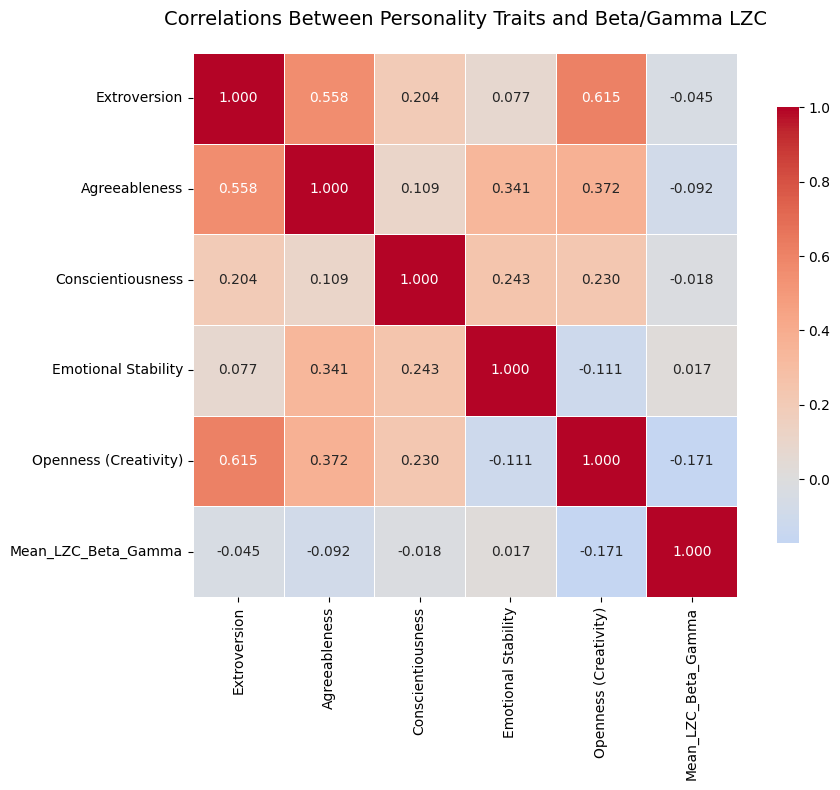

In [42]:
# --------------------------
# 4. Correlation matrix heatmap visualization
# --------------------------

# Select only personality traits + LZC for correlation matrix
cols = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)",
    "Mean_LZC_Beta_Gamma"
]

trait_df = merged_df[cols]

# Compute correlation matrix using Pearson correlation
corr_matrix = trait_df.corr(method="pearson")

print("Correlation Matrix:")
print("=" * 80)
display(corr_matrix)

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0, fmt=".3f", 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlations Between Personality Traits and Beta/Gamma LZC", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [43]:
# Create a new table with participants 1-36 and their mean LZC
# Average of beta1, beta2, gamma1, and gamma2

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]

# Filter participant_mean_lzc_df to only include participants 1-36
filtered_participants = participant_mean_lzc_df.index.intersection(participants_1_to_36)
participant_mean_lzc_subset = participant_mean_lzc_df.loc[filtered_participants]

# Calculate mean of beta1, beta2, gamma1, and gamma2 for each participant
beta_gamma_channels = ['beta1', 'beta2', 'gamma1', 'gamma2']
participant_beta_gamma_mean = participant_mean_lzc_subset[beta_gamma_channels].mean(axis=1)

# Create a DataFrame with participants as rows and the mean LZC as a column
participant_beta_gamma_mean_df = pd.DataFrame({
    'Mean_LZC_Beta_Gamma': participant_beta_gamma_mean
}, index=filtered_participants)

participant_beta_gamma_mean_df


,Mean_LZC_Beta_Gamma
1,3.036575
2,3.077252
3,3.134606
4,3.130790
5,2.880626
6,2.383822
7,2.953857
8,3.068957
10,3.131756
11,2.831956


In [44]:
# Added the participant number from the EEG data to the personality data csv as the index column

personality_df = pd.read_csv('Personality_Details.xls - Results.csv', index_col=0)
personality_df.index = personality_df.index.astype(str)

personality_df

,Subject ID,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity)
1,1,5.4,5.9,5.2,5.1,5.2
2,2,3.0,5.1,4.3,3.7,4.6
3,3,3.9,5.4,4.4,4.8,3.9
4,4,2.9,4.1,5.6,5.7,4.0
5,5,3.2,4.8,6.1,5.7,4.7
6,6,3.5,4.9,5.4,3.9,4.9
7,7,5.5,5.4,5.0,4.3,5.4
8,8,3.1,5.9,4.6,4.4,4.8
9,9,5.9,4.7,3.9,3.0,4.9
10,10,4.9,5.6,5.9,4.0,5.4


In [45]:
# Filter personality_df to drop participants with less than 3 valid trials
personality_filtered_df = personality_df[~personality_df.index.isin(participants_with_less_than_3_valid_trials)]
personality_filtered_df.shape

(54, 6)

In [46]:
# Filter personality_filtered_df to only include participants 1-36
participants_1_to_36 = [str(i) for i in range(1, 37)]
personality_filtered_1_to_36_df = personality_filtered_df.loc[personality_filtered_df.index.intersection(participants_1_to_36)]

personality_filtered_1_to_36_df


,Subject ID,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity)
1,1,5.4,5.9,5.2,5.1,5.2
2,2,3.0,5.1,4.3,3.7,4.6
3,3,3.9,5.4,4.4,4.8,3.9
4,4,2.9,4.1,5.6,5.7,4.0
5,5,3.2,4.8,6.1,5.7,4.7
6,6,3.5,4.9,5.4,3.9,4.9
7,7,5.5,5.4,5.0,4.3,5.4
8,8,3.1,5.9,4.6,4.4,4.8
10,10,4.9,5.6,5.9,4.0,5.4
11,11,6.2,5.9,4.8,4.7,5.5


In [47]:
# Filter participant_mean_lzc_df to only include participants 1-36
participants_1_to_36 = [str(i) for i in range(1, 37)]
participant_mean_lzc_df_1_to_36 = participant_mean_lzc_df.loc[participant_mean_lzc_df.index.intersection(participants_1_to_36)]

participant_mean_lzc_df_1_to_36

,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
1,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411
2,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180
3,8.011520,3.233364,3.234732,3.165413,3.164423,3.045352,3.179710,3.148939
4,7.809252,3.181674,3.227305,3.139106,3.125650,3.135397,3.149707,3.112407
5,7.434075,2.875605,2.848425,2.889227,2.857680,2.820703,2.922773,2.921347
6,7.235566,2.665344,2.689426,2.804427,2.000000,2.760387,2.000000,2.774899
7,8.255093,2.967559,2.978760,2.850816,3.030078,2.894845,2.925311,2.965194
8,8.091651,3.191324,3.188345,2.986765,3.036135,3.104512,3.087578,3.047605
10,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749
11,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390


In [48]:
# Create a new table with participants 1-36 and their mean LZC for gamma1 and gamma2 only
# Average of gamma1 and gamma2 (excluding beta waves)

# Filter to participants 1-36 (as strings)
participants_1_to_36 = [str(i) for i in range(1, 37)]

# Filter participant_mean_lzc_df to only include participants 1-36
filtered_participants = participant_mean_lzc_df.index.intersection(participants_1_to_36)
participant_mean_lzc_subset = participant_mean_lzc_df.loc[filtered_participants]

# Calculate mean of gamma1 and gamma2 for each participant
gamma_channels = ['gamma1', 'gamma2']
participant_gamma_mean = participant_mean_lzc_subset[gamma_channels].mean(axis=1)

# Create a DataFrame with participants as rows and the mean LZC as a column
participant_gamma_mean_df = pd.DataFrame({
    'Mean_LZC_Gamma': participant_gamma_mean
}, index=filtered_participants)

participant_gamma_mean_df

,Mean_LZC_Gamma
1,3.037726
2,3.113492
3,3.164324
4,3.131057
5,2.922060
6,2.387449
7,2.945252
8,3.067591
10,3.153761
11,2.868796


In [49]:
# # --------------------------
# # 4. Correlation matrix heatmap visualization (Gamma Only)
# # --------------------------

# # Select only personality traits + LZC for correlation matrix
# cols = [
#     "Extroversion",
#     "Agreeableness",
#     "Conscientiousness",
#     "Emotional Stability",
#     "Openness (Creativity)",
#     "Mean_LZC_Gamma"
# ]

# trait_gamma_df = merged_gamma_df[cols]

# # Compute correlation matrix using Pearson correlation
# corr_gamma_matrix = trait_gamma_df.corr(method="pearson")

# print("Correlation Matrix (Gamma Only):")
# print("=" * 80)
# display(corr_gamma_matrix)

# # Visualization
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_gamma_matrix, annot=True, cmap="coolwarm", center=0, fmt=".3f", 
#             square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
# plt.title("Correlations Between Personality Traits and Gamma LZC (gamma1 & gamma2)", fontsize=14, pad=20)
# plt.tight_layout()
# plt.show()


In [50]:
# Merge EEG and Personality DataFrames and select only relevant columns in one step
personality_cols = [
    "Extroversion",
    "Agreeableness",
    "Conscientiousness",
    "Emotional Stability",
    "Openness (Creativity)"
]

eeg_cols = channels  # delta, theta, alpha1, alpha2, beta1, beta2, gamma1, gamma2

# Merge and select columns in one go
eeg_personality_df = (
    personality_filtered_1_to_36_df.merge(
        participant_mean_lzc_df_1_to_36,
        left_index=True,
        right_index=True,
        how='inner'
    )[personality_cols + eeg_cols].copy()
)

print(f"Subset DataFrame shape: {eeg_personality_df.shape}")
eeg_personality_df.head()

Subset DataFrame shape: (32, 13)


,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity),delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
1,5.4,5.9,5.2,5.1,5.2,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411
2,3.0,5.1,4.3,3.7,4.6,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180
3,3.9,5.4,4.4,4.8,3.9,8.011520,3.233364,3.234732,3.165413,3.164423,3.045352,3.179710,3.148939
4,2.9,4.1,5.6,5.7,4.0,7.809252,3.181674,3.227305,3.139106,3.125650,3.135397,3.149707,3.112407
5,3.2,4.8,6.1,5.7,4.7,7.434075,2.875605,2.848425,2.889227,2.857680,2.820703,2.922773,2.921347


Full Correlation Matrix:


,Extroversion,Agreeableness,Conscientiousness,Emotional Stability,Openness (Creativity),delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
Extroversion,1.000000,0.557771,0.204181,0.077285,0.614873,0.083645,-0.093839,-0.241025,-0.170815,-0.017175,-0.016114,-0.059627,-0.089689
Agreeableness,0.557771,1.000000,0.108796,0.341494,0.371731,-0.000845,-0.011160,-0.129221,-0.211297,-0.057135,-0.169694,-0.059359,-0.113151
Conscientiousness,0.204181,0.108796,1.000000,0.243483,0.230033,-0.103773,0.202469,-0.169907,-0.132577,-0.034079,-0.029963,0.028556,-0.085209
Emotional Stability,0.077285,0.341494,0.243483,1.000000,-0.110795,-0.175283,0.396712,0.023609,-0.278370,0.021910,-0.109611,0.096491,-0.067071
Openness (Creativity),0.614873,0.371731,0.230033,-0.110795,1.000000,-0.051087,-0.085634,-0.316227,-0.251317,-0.132509,0.004588,-0.242180,-0.186830
delta,0.083645,-0.000845,-0.103773,-0.175283,-0.051087,1.000000,0.161180,0.695356,0.543157,0.624431,0.269037,0.597472,0.652454
theta,-0.093839,-0.011160,0.202469,0.396712,-0.085634,0.161180,1.000000,0.328285,-0.107917,0.322849,0.013584,0.356688,0.270269
alpha1,-0.241025,-0.129221,-0.169907,0.023609,-0.316227,0.695356,0.328285,1.000000,0.646742,0.701885,0.468465,0.672987,0.758046
alpha2,-0.170815,-0.211297,-0.132577,-0.278370,-0.251317,0.543157,-0.107917,0.646742,1.000000,0.698866,0.613581,0.668586,0.836246
beta1,-0.017175,-0.057135,-0.034079,0.021910,-0.132509,0.624431,0.322849,0.701885,0.698866,1.000000,0.566104,0.950392,0.876699


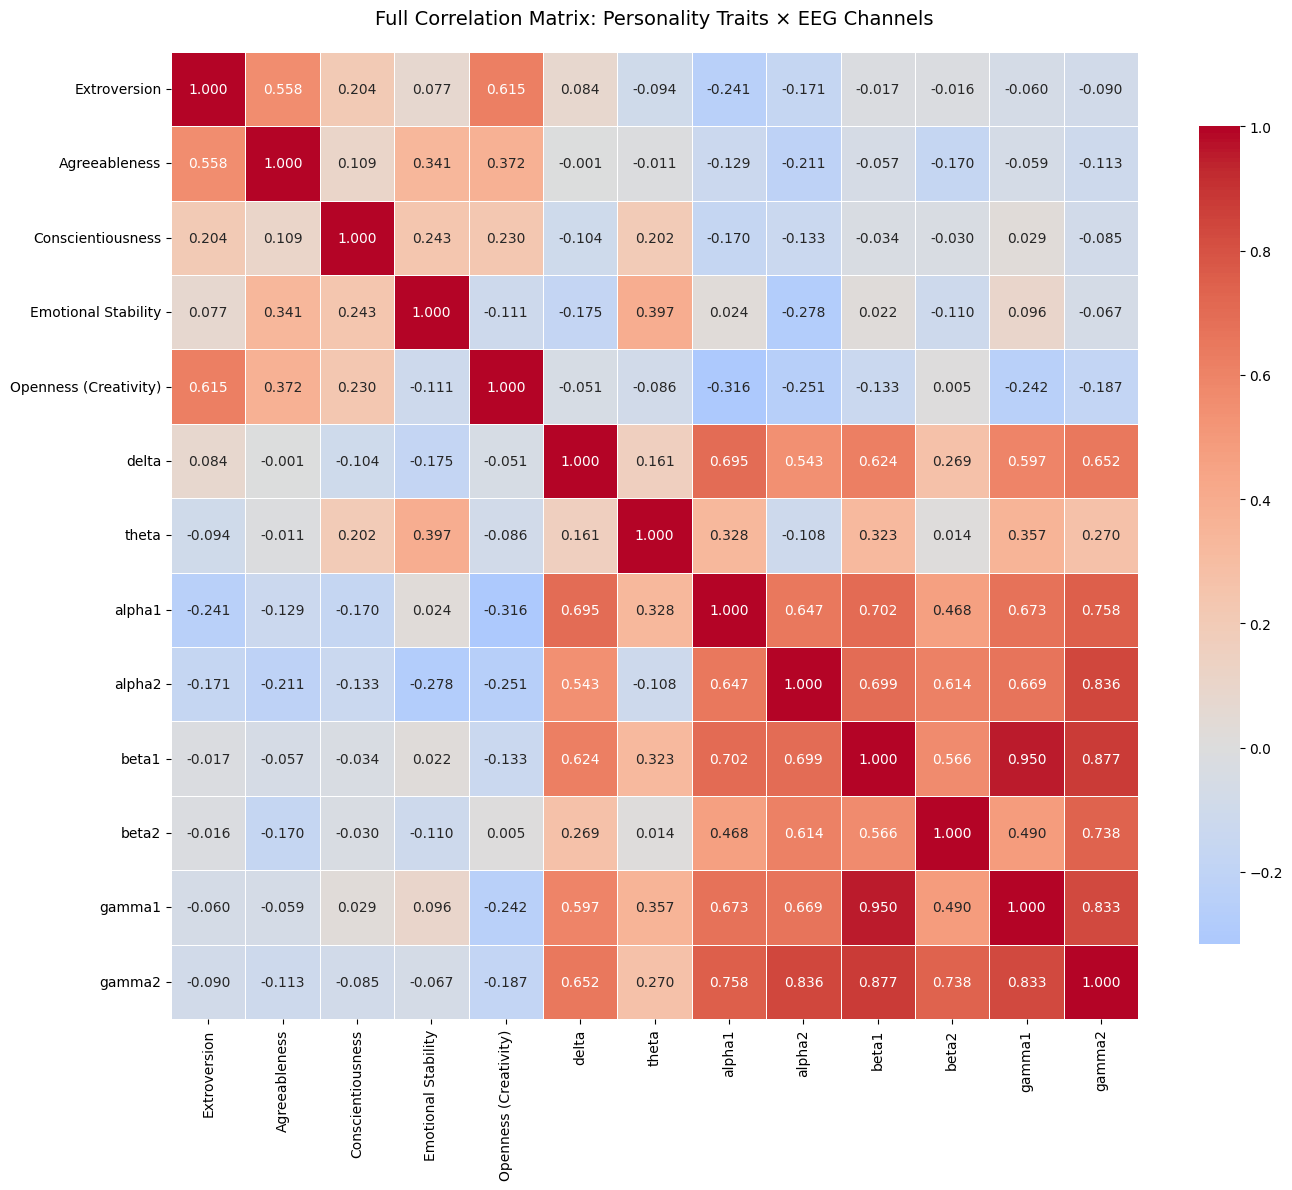

In [51]:
# Step 3: Compute full Pearson correlation matrix (all variables)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Calculate correlation matrix for all personality and EEG variables
eeg_personality_corr_matrix = eeg_personality_df.corr(method='pearson')

print("Full Correlation Matrix:")
print("=" * 80)
display(eeg_personality_corr_matrix)

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(eeg_personality_corr_matrix, annot=True, cmap="coolwarm", center=0, 
            fmt=".3f", square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Full Correlation Matrix: Personality Traits × EEG Channels", fontsize=14, pad=20)
plt.tight_layout()
plt.show()


In [52]:
# Step 5: Compute pairwise correlations with p-values
# For every combination of personality trait and EEG channel

results_list = []

for trait in personality_cols:
    for channel in eeg_cols:
        # Get valid pairs (drop NaN values)
        valid_data = eeg_personality_df[[trait, channel]].dropna()
        
        if len(valid_data) > 2:  # Need at least 3 points for correlation
            # Pearson correlation with p-value
            r, p = stats.pearsonr(valid_data[trait], valid_data[channel])
            
            results_list.append({
                "Personality_Trait": trait,
                "EEG_Channel": channel,
                "Pearson_r": r,
                "p_value": p,
            })
        else:
            results_list.append({
                "Personality_Trait": trait,
                "EEG_Channel": channel,
                "Pearson_r": np.nan,
                "p_value": np.nan,
            })

# Create DataFrame with correlation statistics
eeg_personality_corrstats_df = pd.DataFrame(results_list)

print("Correlation Statistics:")
print("=" * 80)
display(eeg_personality_corrstats_df)


Correlation Statistics:


,Personality_Trait,EEG_Channel,Pearson_r,p_value
0,Extroversion,delta,0.083645,0.649007
1,Extroversion,theta,-0.093839,0.609459
2,Extroversion,alpha1,-0.241025,0.183886
3,Extroversion,alpha2,-0.170815,0.349930
4,Extroversion,beta1,-0.017175,0.925666
5,Extroversion,beta2,-0.016114,0.930247
6,Extroversion,gamma1,-0.059627,0.745811
7,Extroversion,gamma2,-0.089689,0.625438
8,Agreeableness,delta,-0.000845,0.996339
9,Agreeableness,theta,-0.011160,0.951660


In [53]:
# Step 6: Apply FDR correction (Benjamini-Hochberg)
from statsmodels.stats.multitest import multipletests

# Extract p-values (excluding NaN values)
p_values = eeg_personality_corrstats_df['p_value'].values
valid_mask = ~np.isnan(p_values)

# Apply FDR correction only to valid p-values
if np.any(valid_mask):
    p_fdr_corrected = np.full(len(p_values), np.nan)
    _, p_fdr_corrected[valid_mask], _, _ = multipletests(
        p_values[valid_mask], 
        alpha=0.05, 
        method='fdr_bh'
    )
    
    eeg_personality_corrstats_df['p_fdr'] = p_fdr_corrected
    eeg_personality_corrstats_df['significant_fdr'] = eeg_personality_corrstats_df['p_fdr'] < 0.05
else:
    eeg_personality_corrstats_df['p_fdr'] = np.nan
    eeg_personality_corrstats_df['significant_fdr'] = False

print("Correlation Statistics with FDR Correction:")
print("=" * 80)
display(eeg_personality_corrstats_df)

print(f"\nNumber of significant correlations (FDR < 0.05): {eeg_personality_corrstats_df['significant_fdr'].sum()}")


Correlation Statistics with FDR Correction:


,Personality_Trait,EEG_Channel,Pearson_r,p_value,p_fdr,significant_fdr
0,Extroversion,delta,0.083645,0.649007,0.996339,False
1,Extroversion,theta,-0.093839,0.609459,0.996339,False
2,Extroversion,alpha1,-0.241025,0.183886,0.996339,False
3,Extroversion,alpha2,-0.170815,0.349930,0.996339,False
4,Extroversion,beta1,-0.017175,0.925666,0.996339,False
5,Extroversion,beta2,-0.016114,0.930247,0.996339,False
6,Extroversion,gamma1,-0.059627,0.745811,0.996339,False
7,Extroversion,gamma2,-0.089689,0.625438,0.996339,False
8,Agreeableness,delta,-0.000845,0.996339,0.996339,False
9,Agreeableness,theta,-0.011160,0.951660,0.996339,False



Number of significant correlations (FDR < 0.05): 0


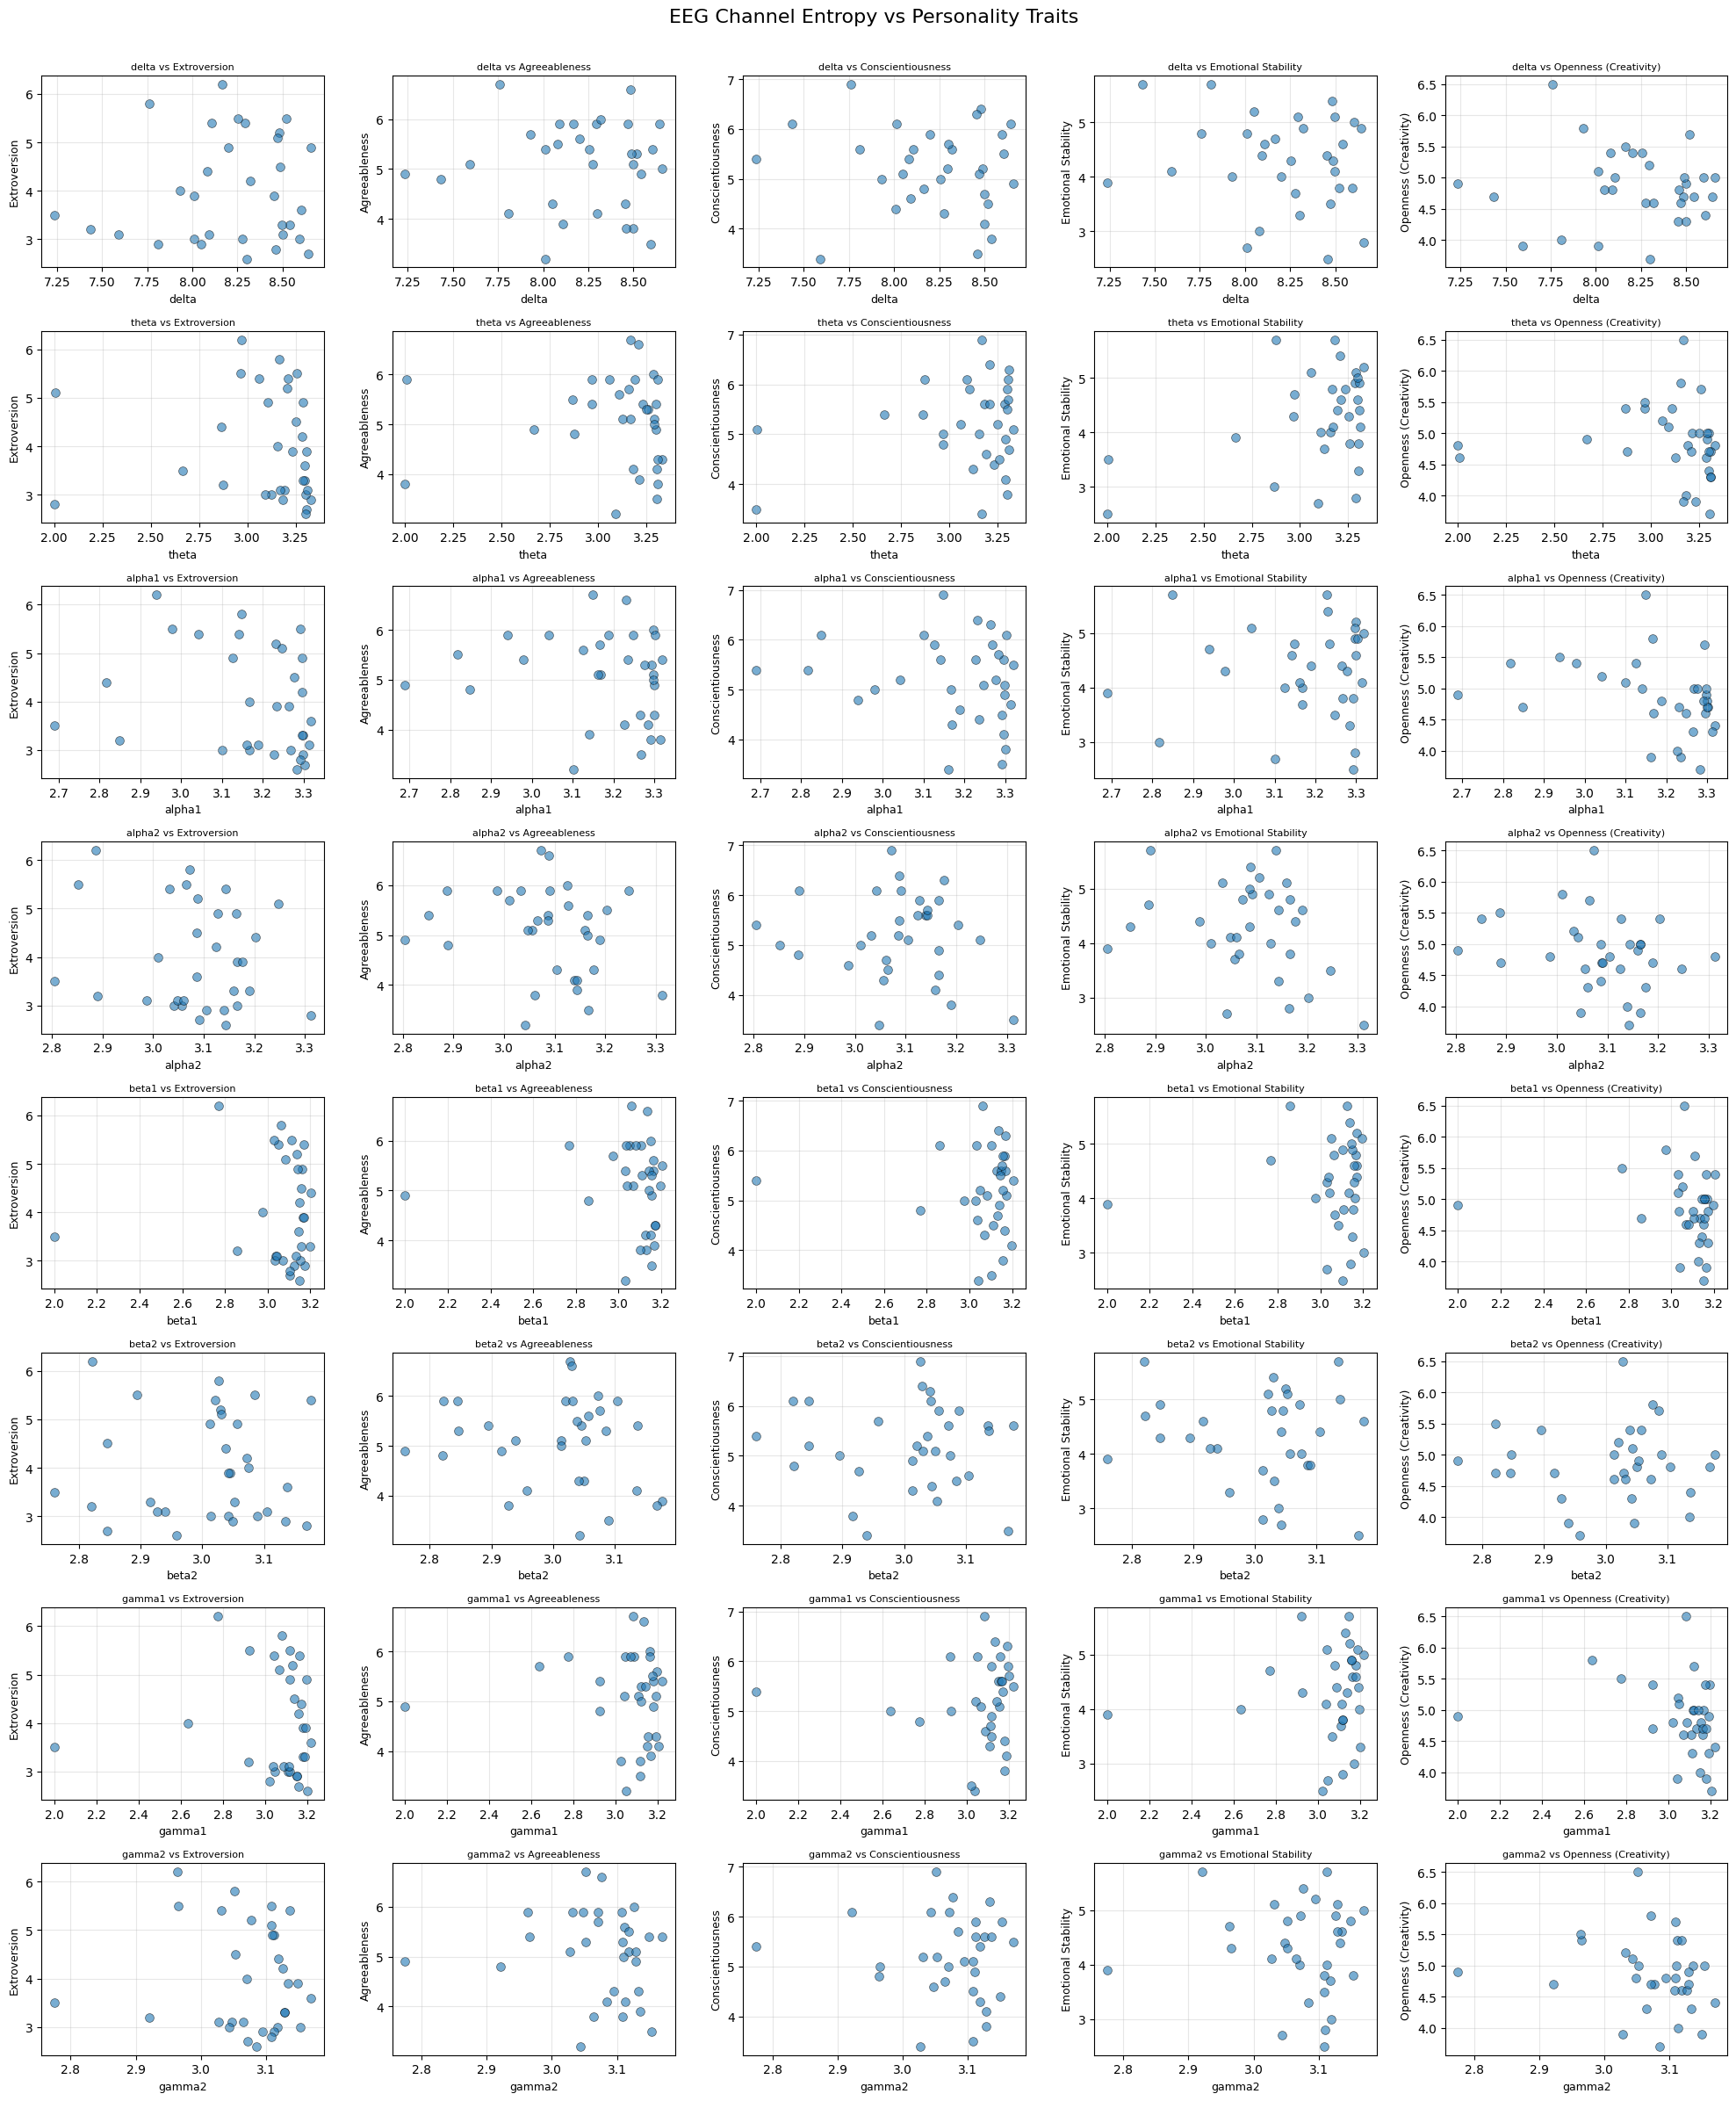

In [54]:
# Generate scatter plots for all combinations of personality traits and EEG channels
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with 8 rows (channels) × 5 columns (traits)
fig, axes = plt.subplots(8, 5, figsize=(20, 24))
fig.suptitle('EEG Channel Entropy vs Personality Traits', fontsize=16, y=0.995)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

plot_idx = 0
for channel in eeg_cols:
    for trait in personality_cols:
        ax = axes_flat[plot_idx]
        
        # Create scatter plot
        ax.scatter(
            eeg_personality_df[channel], 
            eeg_personality_df[trait],
            alpha=0.6,
            s=50,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Set labels
        ax.set_xlabel(channel, fontsize=9)
        ax.set_ylabel(trait, fontsize=9)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
        
        # Set title (channel - trait)
        ax.set_title(f'{channel} vs {trait}', fontsize=8, pad=5)
        
        plot_idx += 1

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


In [55]:
# Load self-reports from MATLAB file
# Load the .mat file
self_reports_mat = loadmat('Dt_SelfReports.mat', struct_as_record=False, squeeze_me=True)

# Access the Length struct
# MATLAB structs are accessed differently depending on how they're stored
# First, let's explore the structure
print("Keys in the loaded file:")
print(self_reports_mat.keys())
print("\n" + "="*80 + "\n")

# Try to access Length struct
# MATLAB structs loaded with struct_as_record=False may need different access
if 'Length' in self_reports_mat:
    length_struct = self_reports_mat['Length']
    print(f"Length type: {type(length_struct)}")
    print(f"Length attributes: {dir(length_struct)}")
    
    # Try to access Arousal and Valence
    if hasattr(length_struct, 'Arousal'):
        arousal_data = length_struct.Arousal
        print(f"\nArousal shape: {arousal_data.shape if hasattr(arousal_data, 'shape') else 'N/A'}")
    
    if hasattr(length_struct, 'Valence'):
        valence_data = length_struct.Valence
        print(f"Valence shape: {valence_data.shape if hasattr(valence_data, 'shape') else 'N/A'}")
else:
    # Try alternative loading method
    print("Trying alternative loading method...")
    self_reports_mat_alt = loadmat('Dt_SelfReports.mat', struct_as_record=True)
    print("Keys with struct_as_record=True:")
    print([k for k in self_reports_mat_alt.keys() if not k.startswith('__')])


Keys in the loaded file:
dict_keys(['__header__', '__version__', '__globals__', 'ClipNumbers', 'Length', 'Ratings'])


Length type: <class 'scipy.io.matlab._mio5_params.mat_struct'>
Length attributes: ['Arousal', 'Engaging', 'Familiarity', 'Liking', 'Valence', 'Video', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_fieldnames']

Arousal shape: (58, 36)
Valence shape: (58, 36)


In [56]:
# Extract Arousal and Valence data and convert to pandas DataFrames
# with row numbers and column numbers as labels

# Access the Length struct
length_struct = self_reports_mat['Length']

# Extract Arousal and Valence arrays
arousal_array = length_struct.Arousal  # Shape: (58, 36)
valence_array = length_struct.Valence  # Shape: (58, 36)

# Create DataFrames with row labels as strings '1'-'58' and column labels as integers 1-36
arousal_df = pd.DataFrame(
    arousal_array,
    index=[str(i) for i in range(1, arousal_array.shape[0]+1)],   # Row labels: '1', '2', ..., '58'
    columns=range(1, arousal_array.shape[1]+1)                     # Column labels: 1, 2, ..., 36
)

valence_df = pd.DataFrame(
    valence_array,
    index=[str(i) for i in range(1, valence_array.shape[0]+1)],   # Row labels: '1', ..., '58'
    columns=range(1, valence_array.shape[1]+1)                     # Column labels: 1, ..., 36
)

print(arousal_df.shape)
print(valence_df.shape)

(58, 36)
(58, 36)


In [57]:
valence_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,6.139229,4.025376,10.689520,5.606943,23.662280,4.104589,3.456985,3.071605,4.672605,4.336009,...,6.386195,4.705156,18.823910,4.461604,6.540634,6.856246,2.984583,2.286861,7.378102,3.078223
2,2.829555,6.030153,2.576858,3.594747,3.864701,4.667713,5.795453,2.950242,2.364043,2.393369,...,8.311491,6.013884,5.966948,3.333859,7.781446,6.767087,6.947012,2.378709,4.160272,6.996563
3,4.316488,10.434269,18.360881,5.565879,4.346767,4.698279,3.727653,3.977980,4.532356,8.477862,...,4.293893,5.315488,9.381229,11.930243,10.695164,6.617795,5.234649,9.529063,8.409773,2.850454
4,3.161881,5.358496,2.796220,1.278880,3.065238,1.914931,3.033180,3.931195,3.267469,2.430879,...,4.997509,4.266523,4.061751,7.763762,3.430128,5.963641,4.428645,10.066237,4.918441,4.842722
5,1.228801,1.581660,2.015920,1.246328,6.847105,2.663997,2.778929,2.696457,1.951057,3.078459,...,3.331508,2.402615,4.430660,9.600660,3.549580,3.163023,2.632614,2.734733,2.926042,3.746746
6,2.042443,9.464420,3.479689,4.396492,2.152139,2.264834,5.765886,3.984063,3.598143,3.977833,...,11.566304,3.981245,4.884695,9.431135,3.079355,3.367872,3.562964,3.531487,6.116865,6.017631
7,2.799250,1.718888,2.617886,2.977685,1.820816,1.429544,3.127486,2.184113,1.900826,1.262036,...,2.745607,8.281268,3.096401,3.264118,3.781794,2.563419,2.583504,4.303777,4.228310,3.765057
8,4.360562,4.336739,6.247934,4.032780,4.235629,3.258017,5.050869,3.149450,4.344939,6.822004,...,4.195730,2.687404,3.413091,3.933163,4.251119,4.865673,2.815224,3.360678,2.254173,2.966248
9,2.316977,2.642404,2.797836,8.209032,3.581742,2.963370,4.447634,2.950769,2.228923,4.547685,...,11.592938,6.748535,5.177900,5.882261,4.428766,6.984216,3.711123,4.983762,8.700230,3.514686
10,1.899346,3.186029,3.214321,2.733407,3.797360,6.161974,2.062297,6.167248,5.250927,2.128495,...,2.847489,5.233033,4.213187,3.710916,4.475324,4.396397,9.863657,3.417407,4.634813,4.367300


In [58]:
# Filter arousal_df and valence_df to only include rows matching participant_mean_lzc_df_1_to_36
# Get the matching participant row labels
matching_participants = arousal_df.index.intersection(participant_mean_lzc_df_1_to_36.index)

# Filter both DataFrames to only include matching rows
arousal_df_filtered = arousal_df.loc[matching_participants]
valence_df_filtered = valence_df.loc[matching_participants]

print(arousal_df_filtered.shape)
print(valence_df_filtered.shape)

(32, 36)
(32, 36)


In [59]:
valence_df_filtered.head()

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,6.139229,4.025376,10.689520,5.606943,23.662280,4.104589,3.456985,3.071605,4.672605,4.336009,...,6.386195,4.705156,18.823910,4.461604,6.540634,6.856246,2.984583,2.286861,7.378102,3.078223
2,2.829555,6.030153,2.576858,3.594747,3.864701,4.667713,5.795453,2.950242,2.364043,2.393369,...,8.311491,6.013884,5.966948,3.333859,7.781446,6.767087,6.947012,2.378709,4.160272,6.996563
3,4.316488,10.434269,18.360881,5.565879,4.346767,4.698279,3.727653,3.977980,4.532356,8.477862,...,4.293893,5.315488,9.381229,11.930243,10.695164,6.617795,5.234649,9.529063,8.409773,2.850454
4,3.161881,5.358496,2.796220,1.278880,3.065238,1.914931,3.033180,3.931195,3.267469,2.430879,...,4.997509,4.266523,4.061751,7.763762,3.430128,5.963641,4.428645,10.066237,4.918441,4.842722
5,1.228801,1.581660,2.015920,1.246328,6.847105,2.663997,2.778929,2.696457,1.951057,3.078459,...,3.331508,2.402615,4.430660,9.600660,3.549580,3.163023,2.632614,2.734733,2.926042,3.746746


In [60]:
# Create a filtered version of lzc_filtered_df for participants 1-36 only
participants_1_to_36 = [str(i) for i in range(1, 37)]  # '1' to '36' as strings

# Filter lzc_filtered_df to only include participants 1-36
lzc_filtered_df_1_to_36 = lzc_filtered_df.loc[lzc_filtered_df.index.intersection(participants_1_to_36)]

lzc_filtered_df_1_to_36


,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,"[8.0, 3.0588235294117645, 3.1176470588235294, ...","[8.363636363636363, 2.878787878787879, 2.84848...","[8.666666666666666, 3.4444444444444446, 3.2592...",None,"[8.9, 3.32, 3.22, 2.8, 2.62, 3.34, 3.14, 3.16]",None,"[7.177777777777778, 2.2, 2.2444444444444445, 2...",None,"[8.571428571428571, 3.2285714285714286, 3.3142...",None,...,None,"[8.295454545454545, 3.3863636363636362, 3.4545...","[8.186046511627907, 2.883720930232558, 2.67441...",None,"[7.140625, 2.84375, 2.828125, 2.828125, 2.8281...",None,"[8.793103448275861, 3.3275862068965516, 3.4655...","[8.6, 3.1333333333333333, 3.2333333333333334, ...",None,"[8.35483870967742, 3.0, 3.032258064516129, 3.0..."
2,"[8.176470588235293, 3.235294117647059, 3.21568...",None,None,"[8.261904761904763, 3.1666666666666665, 3.3333...","[8.46, 3.18, 3.24, 3.06, 3.08, 3.02, 3.02, 3.06]",None,"[8.355555555555556, 3.4, 3.2666666666666666, 2...","[8.242424242424242, 3.1818181818181817, 3.0909...","[8.714285714285714, 3.2, 3.1142857142857143, 3...","[8.222222222222221, 3.0444444444444443, 3.1777...",...,"[8.17142857142857, 3.0285714285714285, 3.14285...","[8.318181818181818, 3.1363636363636362, 3.2727...","[8.767441860465116, 3.3255813953488373, 3.2790...","[8.256410256410257, 2.8461538461538463, 2.6923...","[8.640625, 3.171875, 3.265625, 3.21875, 3.1406...","[8.185185185185185, 3.1481481481481484, 3.1481...","[8.551724137931034, 3.3448275862068964, 3.2758...","[7.9, 3.0, 2.9, 3.066666666666667, 3.033333333...","[8.444444444444445, 3.1555555555555554, 3.2, 3...","[8.387096774193548, 3.161290322580645, 3.29032..."
3,"[8.509803921568627, 3.176470588235294, 3.29411...","[8.606060606060606, 3.121212121212121, 3.30303...","[8.814814814814815, 3.3333333333333335, 3.1481...","[7.857142857142857, 3.261904761904762, 3.33333...","[7.12, 3.28, 3.16, 3.08, 3.18, 3.16, 3.18, 3.08]","[7.0, 3.423076923076923, 3.3076923076923075, 3...","[7.2, 3.2888888888888888, 3.3333333333333335, ...","[8.181818181818182, 3.272727272727273, 3.36363...","[7.085714285714285, 3.085714285714286, 3.14285...","[8.11111111111111, 3.2444444444444445, 3.15555...",...,"[8.6, 3.3142857142857145, 3.2285714285714286, ...",None,"[7.744186046511628, 3.186046511627907, 3.34883...","[8.564102564102564, 3.1538461538461537, 3.3589...","[8.234375, 3.265625, 3.390625, 3.21875, 3.2031...","[8.11111111111111, 3.259259259259259, 3.148148...","[8.53448275862069, 3.2758620689655173, 3.29310...","[8.466666666666667, 3.2333333333333334, 3.4, 3...","[7.688888888888889, 3.022222222222222, 3.15555...","[7.645161290322581, 3.129032258064516, 3.06451..."
4,"[7.8431372549019605, 3.2941176470588234, 3.254...","[8.242424242424242, 3.212121212121212, 3.12121...","[7.962962962962963, 3.4074074074074074, 3.2592...","[7.738095238095238, 3.119047619047619, 3.16666...","[7.46, 3.36, 3.22, 3.18, 3.22, 3.12, 3.2, 3.06]","[7.8076923076923075, 3.076923076923077, 3.1923...","[7.111111111111111, 3.066666666666667, 3.02222...","[7.878787878787879, 3.272727272727273, 3.42424...","[7.942857142857143, 3.2857142857142856, 3.1142...","[8.177777777777777, 3.2444444444444445, 3.2888...",...,"[8.0, 2.6285714285714286, 3.342857142857143, 2...","[8.204545454545455, 3.2954545454545454, 3.4318...","[7.744186046511628, 3.395348837209302, 3.37209...","[8.076923076923077, 3.3846153846153846, 3.4358...","[7.890625, 2.6875, 2.609375, 2.96875, 2.921875...","[8.25925925925926, 3.2962962962962963, 3.37037...","[7.224137931034483, 2.7758620689655173, 2.7413...","[7.233333333333333, 3.3, 3.1666666666666665, 3...","[8.28888888888889, 3.2, 3.2888888888888888, 2....",None
5,None,None,None,"[5.9523809523809526, 3.1666666666666665, 3.238...","[5.88, 2.28, 2.26, 2.24, 2.28, 2.28, 2.18, 2.32]",None,None,None,None,None,...,None,"[7.681818181818182, 2.909090909090909, 2.86363...",None,"[8.0, 2.923076923076923, 2.8205128205128207, 2...","[7.140625, 2.890625, 2.84375, 2.9375, 2.84375,...","[8.407407407407407, 2.814814814814815, 2.75925...","[8.5, 3.05

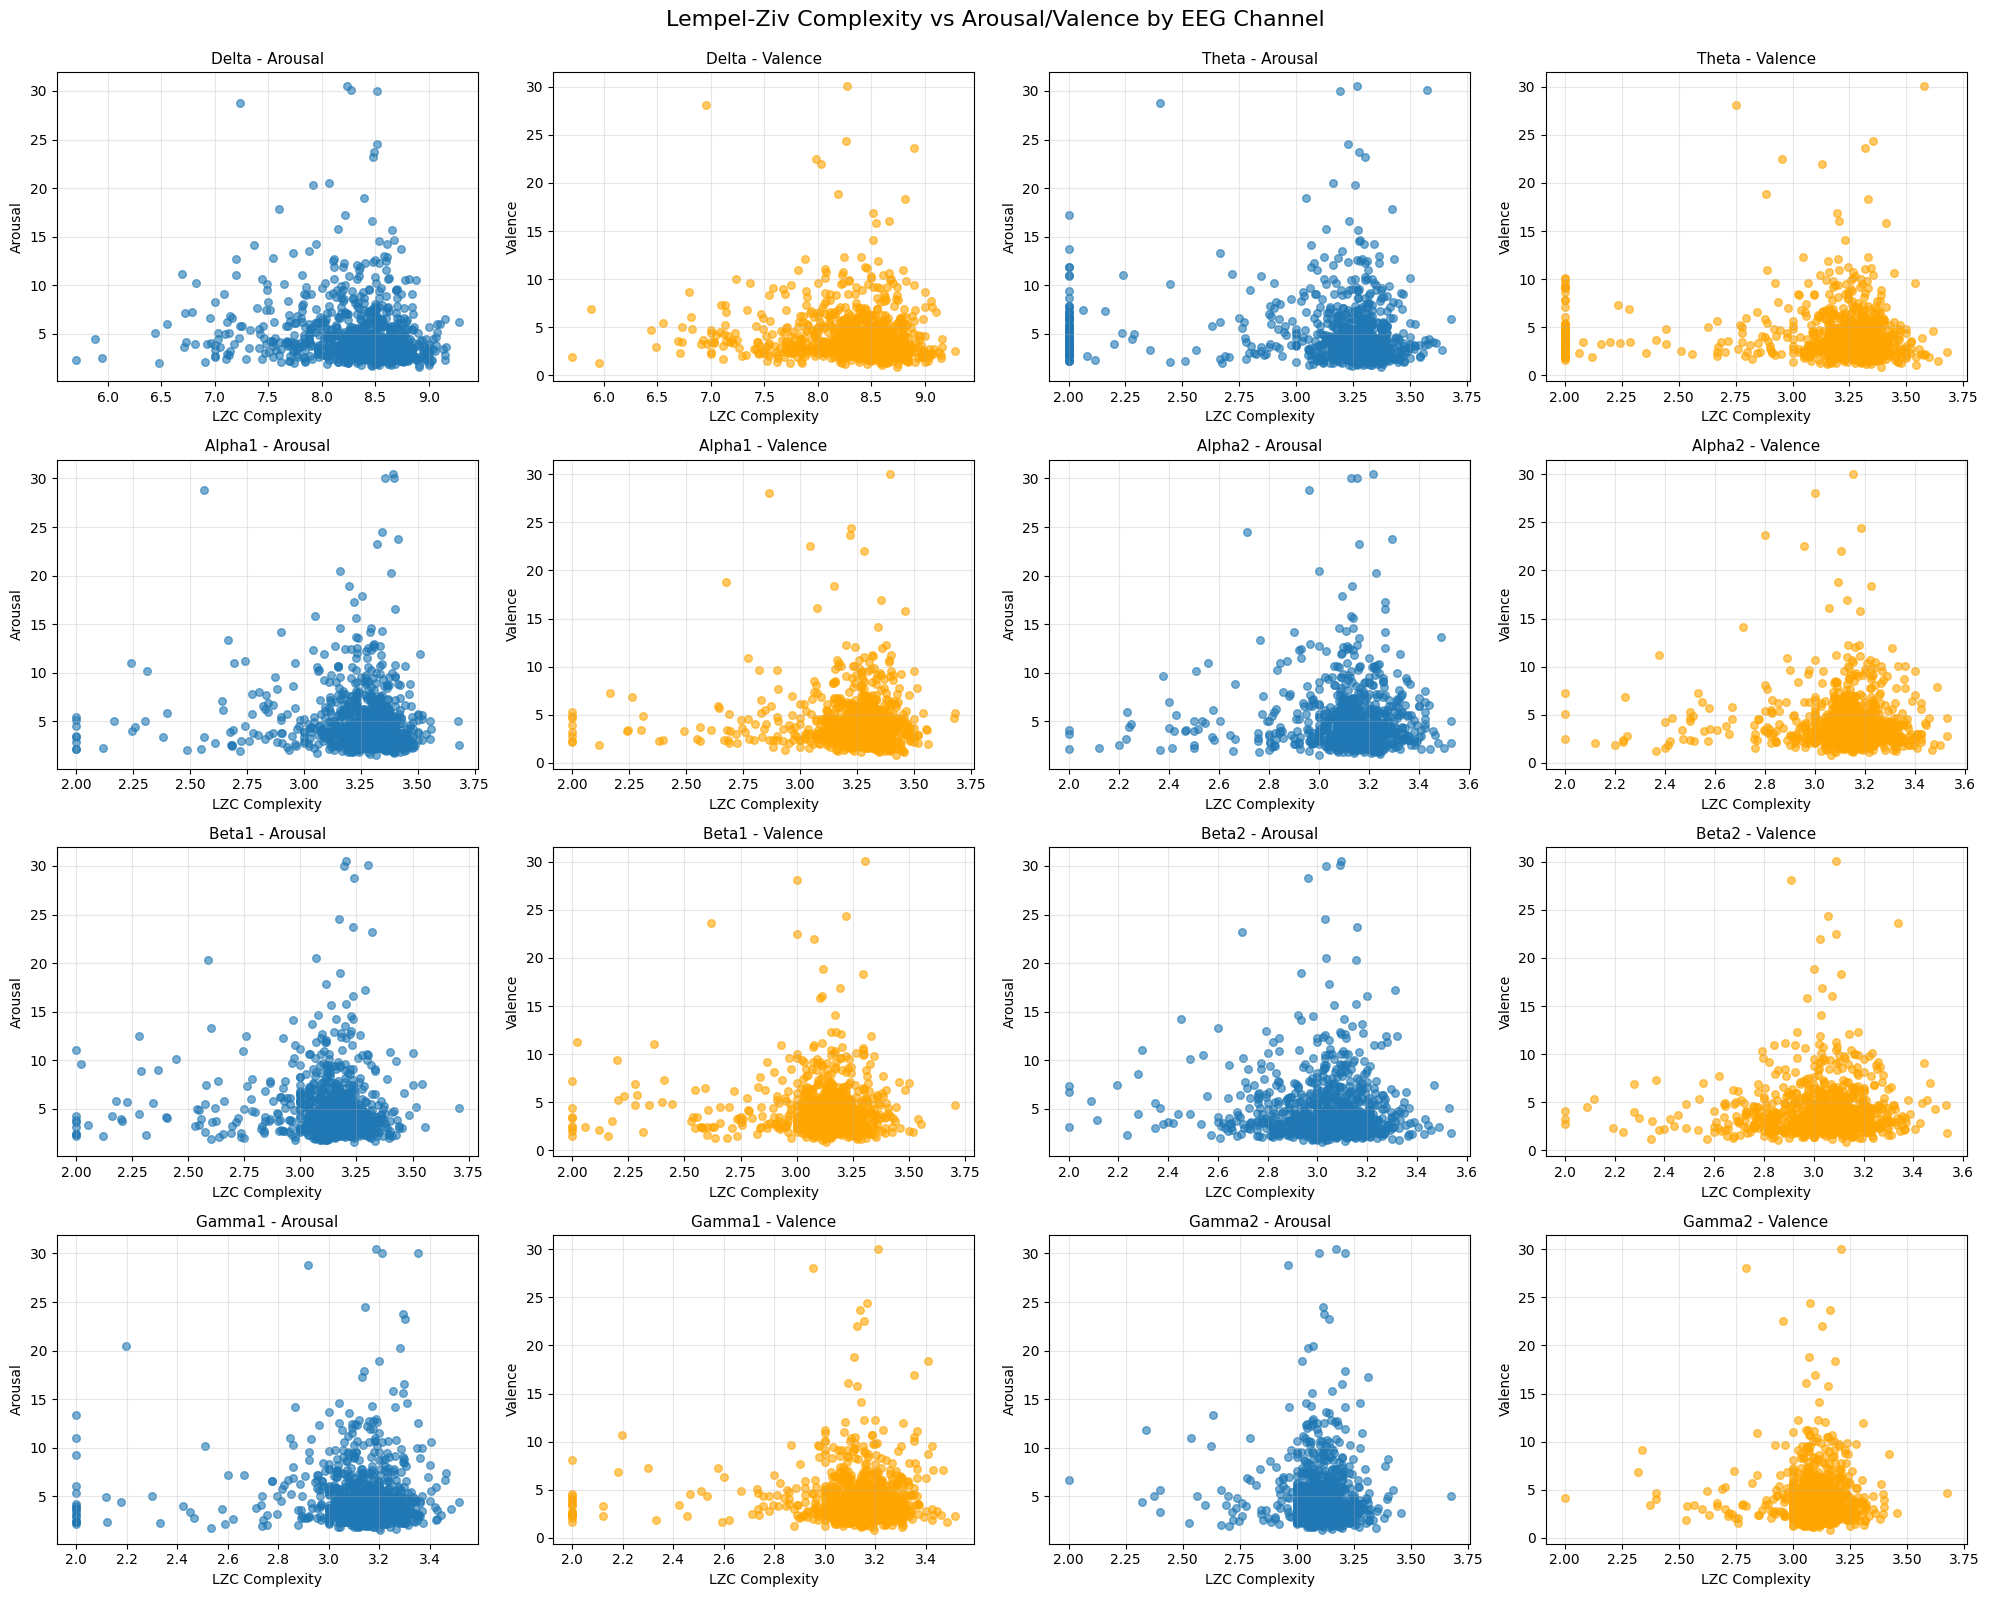

In [61]:
# Create scatter plots for LZC vs Arousal/Valence for all 8 channels
# 16 plots total: 8 channels × 2 measures (arousal, valence)


# Get the channels list
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Create figure with subplots: 4 rows × 4 columns (8 channels × 2 measures)
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Lempel-Ziv Complexity vs Arousal/Valence by EEG Channel', fontsize=16, y=0.995)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

plot_idx = 0

# For each channel
for channel_idx, channel_name in enumerate(channels):
    # Extract data for Arousal
    lzc_arousal = []
    arousal_vals = []
    
    # Extract data for Valence
    lzc_valence = []
    valence_vals = []
    
    # Iterate through all trials (participant × video combinations)
    for participant in lzc_filtered_df_1_to_36.index:
        for video_id in lzc_filtered_df_1_to_36.columns:
            # Get LZC array for this trial
            lzc_array = lzc_filtered_df_1_to_36.at[participant, video_id]
            
            # Skip if None
            if lzc_array is None:
                continue
            
            # Get LZC value for this channel
            if isinstance(lzc_array, np.ndarray) and len(lzc_array) > channel_idx:
                lzc_val = lzc_array[channel_idx]
                
                # Skip if NaN
                if np.isnan(lzc_val):
                    continue
                
                # Get corresponding arousal value
                if participant in arousal_df_filtered.index and video_id in arousal_df_filtered.columns:
                    arousal_val = arousal_df_filtered.at[participant, video_id]
                    if not np.isnan(arousal_val):
                        lzc_arousal.append(lzc_val)
                        arousal_vals.append(arousal_val)
                
                # Get corresponding valence value
                if participant in valence_df_filtered.index and video_id in valence_df_filtered.columns:
                    valence_val = valence_df_filtered.at[participant, video_id]
                    if not np.isnan(valence_val):
                        lzc_valence.append(lzc_val)
                        valence_vals.append(valence_val)
    
    # Plot Arousal
    ax = axes_flat[plot_idx]
    ax.scatter(lzc_arousal, arousal_vals, alpha=0.6, s=30)
    ax.set_xlabel('LZC Complexity', fontsize=10)
    ax.set_ylabel('Arousal', fontsize=10)
    ax.set_title(f'{channel_name.capitalize()} - Arousal', fontsize=11)
    ax.grid(True, alpha=0.3)
    plot_idx += 1
    
    # Plot Valence
    ax = axes_flat[plot_idx]
    ax.scatter(lzc_valence, valence_vals, alpha=0.6, s=30, color='orange')
    ax.set_xlabel('LZC Complexity', fontsize=10)
    ax.set_ylabel('Valence', fontsize=10)
    ax.set_title(f'{channel_name.capitalize()} - Valence', fontsize=11)
    ax.grid(True, alpha=0.3)
    plot_idx += 1

plt.tight_layout()
plt.show()


In [62]:
# Load Arousal.csv
# First column as row indices, first row as column labels
arousal_df = pd.read_csv('Arousal.csv', index_col=0, header=0)

arousal_df = arousal_df.T

arousal_df


,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,1,3,1,6,4,4,3,4,4,4,...,4,5,4,5,6,4,4,1,5,4
2,4,4,5,5,6,2,3,4,4,4,...,2,4,3,3,5,5,5,6,4,5
3,4,3,3,3,4,2,3,3,4,2,...,2,3,4,4,5,4,3,4,4,5
4,4,4,4,5,5,4,4,4,4,4,...,5,5,5,6,5,6,5,4,3,5
5,4,5,5,5,5,4,4,5,6,1,...,2,3,2,4,4,4,5,3,3,4
6,4,4,5,4,4,3,5,4,5,5,...,4,4,3,5,5,4,3,4,4,4
7,3,4,3,4,4,3,4,4,3,4,...,4,3,5,4,4,3,4,3,3,3
8,4,2,3,5,5,5,4,4,4,2,...,2,3,4,2,4,4,5,3,3,4
10,4,4,3,4,4,2,3,3,2,4,...,4,3,4,3,3,5,4,3,3,4
11,4,3,3,5,4,2,2,5,5,2,...,3,4,4,6,3,5,6,4,3,4


In [63]:
# Load Valence.csv
# First column as row indices, first row as column labels
valence_df = pd.read_csv('Valence.csv', index_col=0, header=0)

valence_df = valence_df.T

valence_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,1,2,-2,0,1,0,1,2,2,3,...,-1,-2,-1,0,-2,-1,-1,-2,0,-1
2,3,0,3,2,3,0,1,3,2,2,...,0,0,-1,0,-1,0,0,-3,-1,0
3,2,0,0,1,2,0,1,2,2,1,...,-1,-1,0,-2,-1,-1,0,-3,-2,-1
4,3,3,3,3,3,3,3,3,3,1,...,-1,0,0,0,-1,0,1,-3,-2,0
5,2,2,3,2,2,2,1,2,3,1,...,-2,-2,-2,0,-2,-2,2,-3,-3,-1
6,2,1,3,0,2,1,3,2,3,2,...,1,-1,0,1,-1,-1,0,-2,-1,-1
7,1,2,1,2,2,2,1,3,2,2,...,0,0,-1,0,-1,-1,0,-3,-2,-1
8,0,0,-2,3,2,2,2,2,0,0,...,-3,-1,-1,-1,-2,-2,2,-3,-2,-2
10,2,1,0,0,0,0,0,1,2,2,...,-2,0,-1,-1,-2,-1,0,-3,-1,-1
11,1,1,-1,2,1,1,0,1,2,0,...,-1,-3,-1,-2,-2,-3,-1,-3,-1,-2


In [64]:
# Create arousal_filtered_df by filtering arousal_df based on lzc_filtered_df_1_to_36
# Wherever lzc_filtered_df_1_to_36 has None, set the corresponding cell in arousal_filtered_df to NaN


# Convert index to strings to match lzc_filtered_df_1_to_36
arousal_df.index = arousal_df.index.astype(str)

# Filter to only include participants that are in lzc_filtered_df_1_to_36
matching_participants = arousal_df.index.intersection(lzc_filtered_df_1_to_36.index)
arousal_df_filtered = arousal_df.loc[matching_participants].copy()

# Ensure columns are 1-36 (video clips) and in the same order
arousal_df_filtered = arousal_df_filtered.reindex(columns=range(1, 37))

# Now, for each cell where lzc_filtered_df_1_to_36 has None, set the corresponding cell to NaN
for participant in arousal_df_filtered.index:
    for video_id in arousal_df_filtered.columns:
        # Check if lzc_filtered_df_1_to_36 has None at this position
        if participant in lzc_filtered_df_1_to_36.index and video_id in lzc_filtered_df_1_to_36.columns:
            lzc_value = lzc_filtered_df_1_to_36.at[participant, video_id]
            if lzc_value is None:
                arousal_df_filtered.at[participant, video_id] = np.nan

arousal_filtered_df = arousal_df_filtered

arousal_filtered_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,1.0,3.0,1.0,NaN,4.0,NaN,3.0,NaN,4.0,NaN,...,NaN,5.0,4.0,NaN,6.0,NaN,4.0,1.0,NaN,4.0
2,4.0,NaN,NaN,5.0,6.0,NaN,3.0,4.0,4.0,4.0,...,2.0,4.0,3.0,3.0,5.0,5.0,5.0,6.0,4.0,5.0
3,4.0,3.0,3.0,3.0,4.0,2.0,3.0,3.0,4.0,2.0,...,2.0,NaN,4.0,4.0,5.0,4.0,3.0,4.0,4.0,5.0
4,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,4.0,4.0,...,5.0,5.0,5.0,6.0,5.0,6.0,5.0,4.0,3.0,NaN
5,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,NaN,4.0,4.0,4.0,5.0,3.0,NaN,NaN
6,4.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0
8,4.0,NaN,3.0,NaN,NaN,5.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN
10,4.0,4.0,3.0,4.0,NaN,NaN,NaN,3.0,NaN,4.0,...,4.0,NaN,NaN,3.0,NaN,NaN,4.0,3.0,3.0,NaN
11,4.0,3.0,NaN,5.0,NaN,NaN,2.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,4.0


In [65]:
# Create valence_filtered_df by filtering valence_df based on lzc_filtered_df_1_to_36
# Wherever lzc_filtered_df_1_to_36 has None, set the corresponding cell in valence_filtered_df to NaN


# Convert index to strings to match lzc_filtered_df_1_to_36
valence_df.index = valence_df.index.astype(str)

# Filter to only include participants that are in lzc_filtered_df_1_to_36
matching_participants = valence_df.index.intersection(lzc_filtered_df_1_to_36.index)
valence_df_filtered = valence_df.loc[matching_participants].copy()

# Ensure columns are 1-36 (video clips) and in the same order
valence_df_filtered = valence_df_filtered.reindex(columns=range(1, 37))

# Now, for each cell where lzc_filtered_df_1_to_36 has None, set the corresponding cell to NaN
for participant in valence_df_filtered.index:
    for video_id in valence_df_filtered.columns:
        # Check if lzc_filtered_df_1_to_36 has None at this position
        if participant in lzc_filtered_df_1_to_36.index and video_id in lzc_filtered_df_1_to_36.columns:
            lzc_value = lzc_filtered_df_1_to_36.at[participant, video_id]
            if lzc_value is None:
                valence_df_filtered.at[participant, video_id] = np.nan

valence_filtered_df = valence_df_filtered

valence_filtered_df

,1,2,3,4,5,6,7,8,9,10,...,27,28,29,30,31,32,33,34,35,36
1,1.0,2.0,-2.0,NaN,1.0,NaN,1.0,NaN,2.0,NaN,...,NaN,-2.0,-1.0,NaN,-2.0,NaN,-1.0,-2.0,NaN,-1.0
2,3.0,NaN,NaN,2.0,3.0,NaN,1.0,3.0,2.0,2.0,...,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0,-3.0,-1.0,0.0
3,2.0,0.0,0.0,1.0,2.0,0.0,1.0,2.0,2.0,1.0,...,-1.0,NaN,0.0,-2.0,-1.0,-1.0,0.0,-3.0,-2.0,-1.0
4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,...,-1.0,0.0,0.0,0.0,-1.0,0.0,1.0,-3.0,-2.0,NaN
5,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.0,NaN,0.0,-2.0,-2.0,2.0,-3.0,NaN,NaN
6,2.0,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0
8,0.0,NaN,-2.0,NaN,NaN,2.0,2.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,-3.0,NaN,NaN
10,2.0,1.0,0.0,0.0,NaN,NaN,NaN,1.0,NaN,2.0,...,-2.0,NaN,NaN,-1.0,NaN,NaN,0.0,-3.0,-1.0,NaN
11,1.0,1.0,NaN,2.0,NaN,NaN,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,-3.0,NaN,NaN,NaN,-2.0


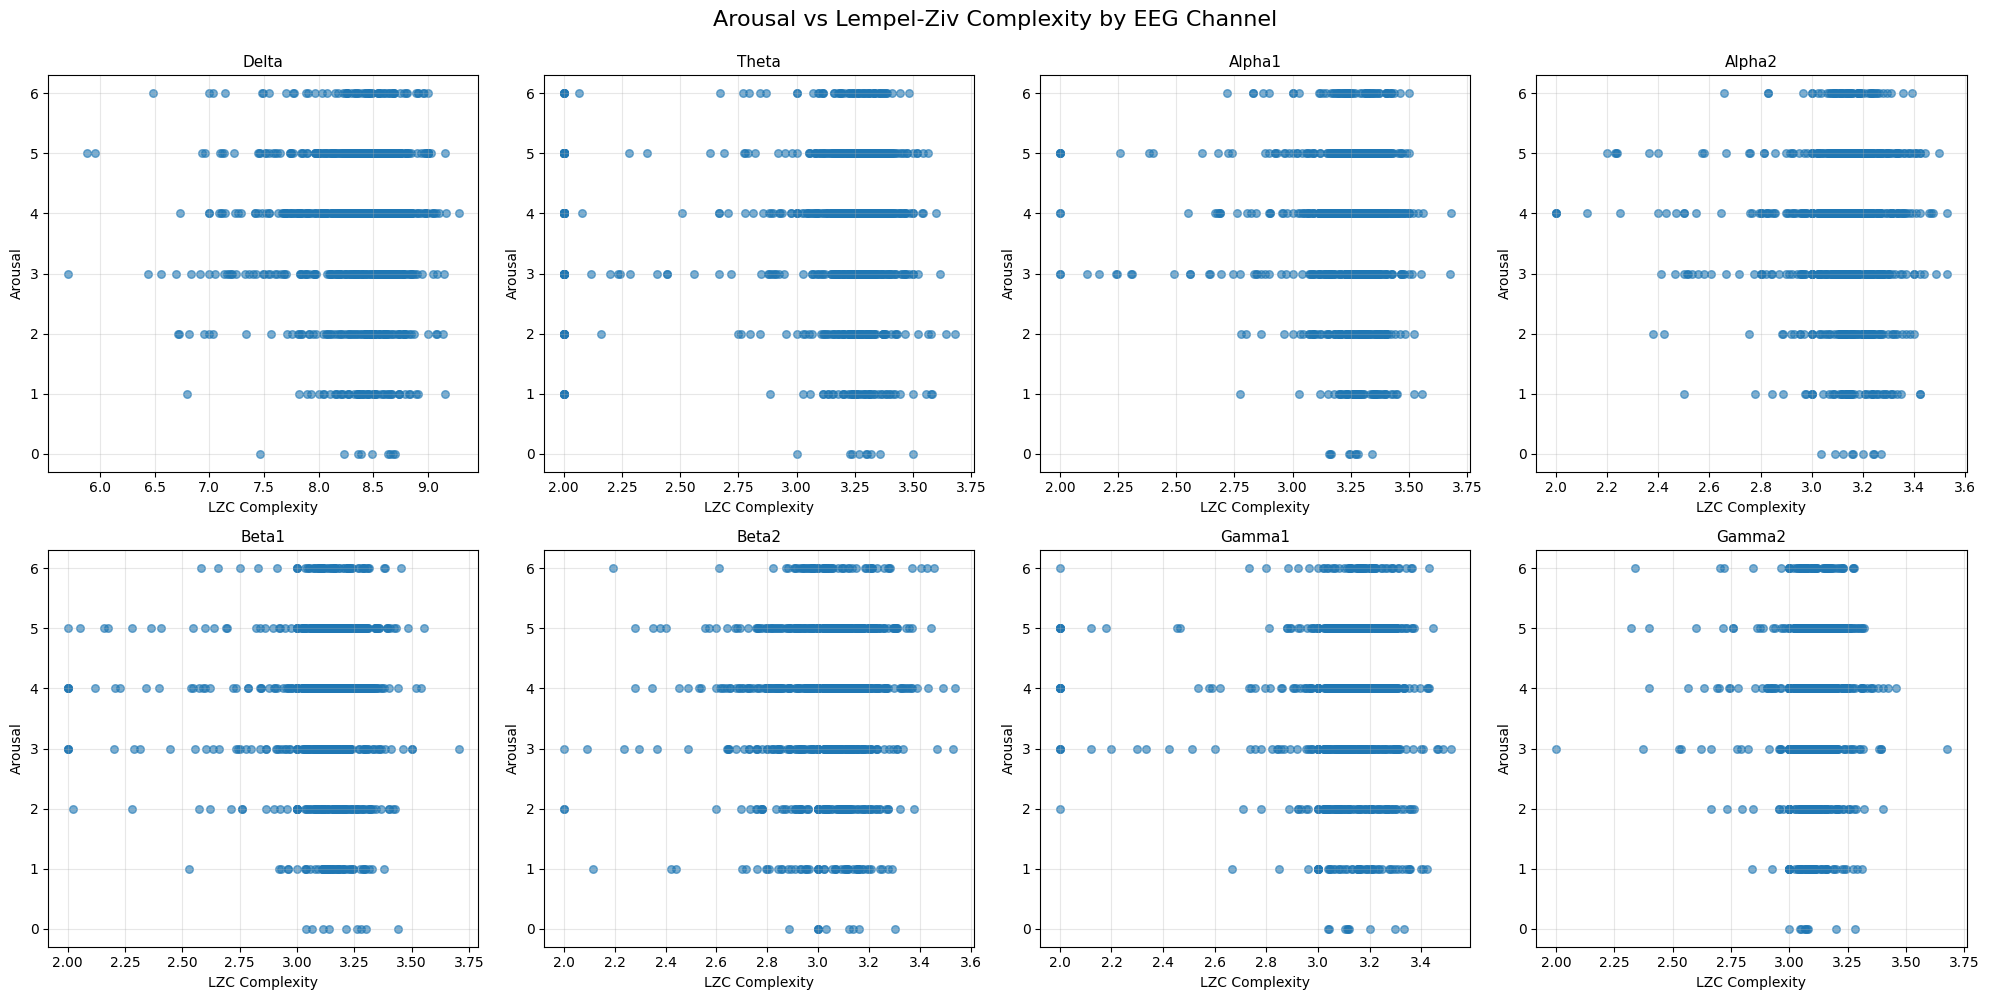

In [66]:
# Create scatter plots for Arousal vs LZC for all 8 channels
# 8 plots total: one for each channel

# Get the channels list
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Create figure with subplots: 2 rows × 4 columns (8 channels)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Arousal vs Lempel-Ziv Complexity by EEG Channel', fontsize=16, y=0.995)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# For each channel
for channel_idx, channel_name in enumerate(channels):
    # Extract data for Arousal
    lzc_vals = []
    arousal_vals = []
    
    # Iterate through all trials (participant × video combinations)
    for participant in lzc_filtered_df_1_to_36.index:
        for video_id in lzc_filtered_df_1_to_36.columns:
            # Get LZC array for this trial
            lzc_array = lzc_filtered_df_1_to_36.at[participant, video_id]
            
            # Skip if None
            if lzc_array is None:
                continue
            
            # Get LZC value for this channel
            if isinstance(lzc_array, np.ndarray) and len(lzc_array) > channel_idx:
                lzc_val = lzc_array[channel_idx]
                
                # Skip if NaN
                if np.isnan(lzc_val):
                    continue
                
                # Get corresponding arousal value from arousal_filtered_df
                if participant in arousal_filtered_df.index and video_id in arousal_filtered_df.columns:
                    arousal_val = arousal_filtered_df.at[participant, video_id]
                    if not np.isnan(arousal_val):
                        lzc_vals.append(lzc_val)
                        arousal_vals.append(arousal_val)
    
    # Plot Arousal vs LZC for this channel
    ax = axes_flat[channel_idx]
    ax.scatter(lzc_vals, arousal_vals, alpha=0.6, s=30)
    ax.set_xlabel('LZC Complexity', fontsize=10)
    ax.set_ylabel('Arousal', fontsize=10)
    ax.set_title(f'{channel_name.capitalize()}', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


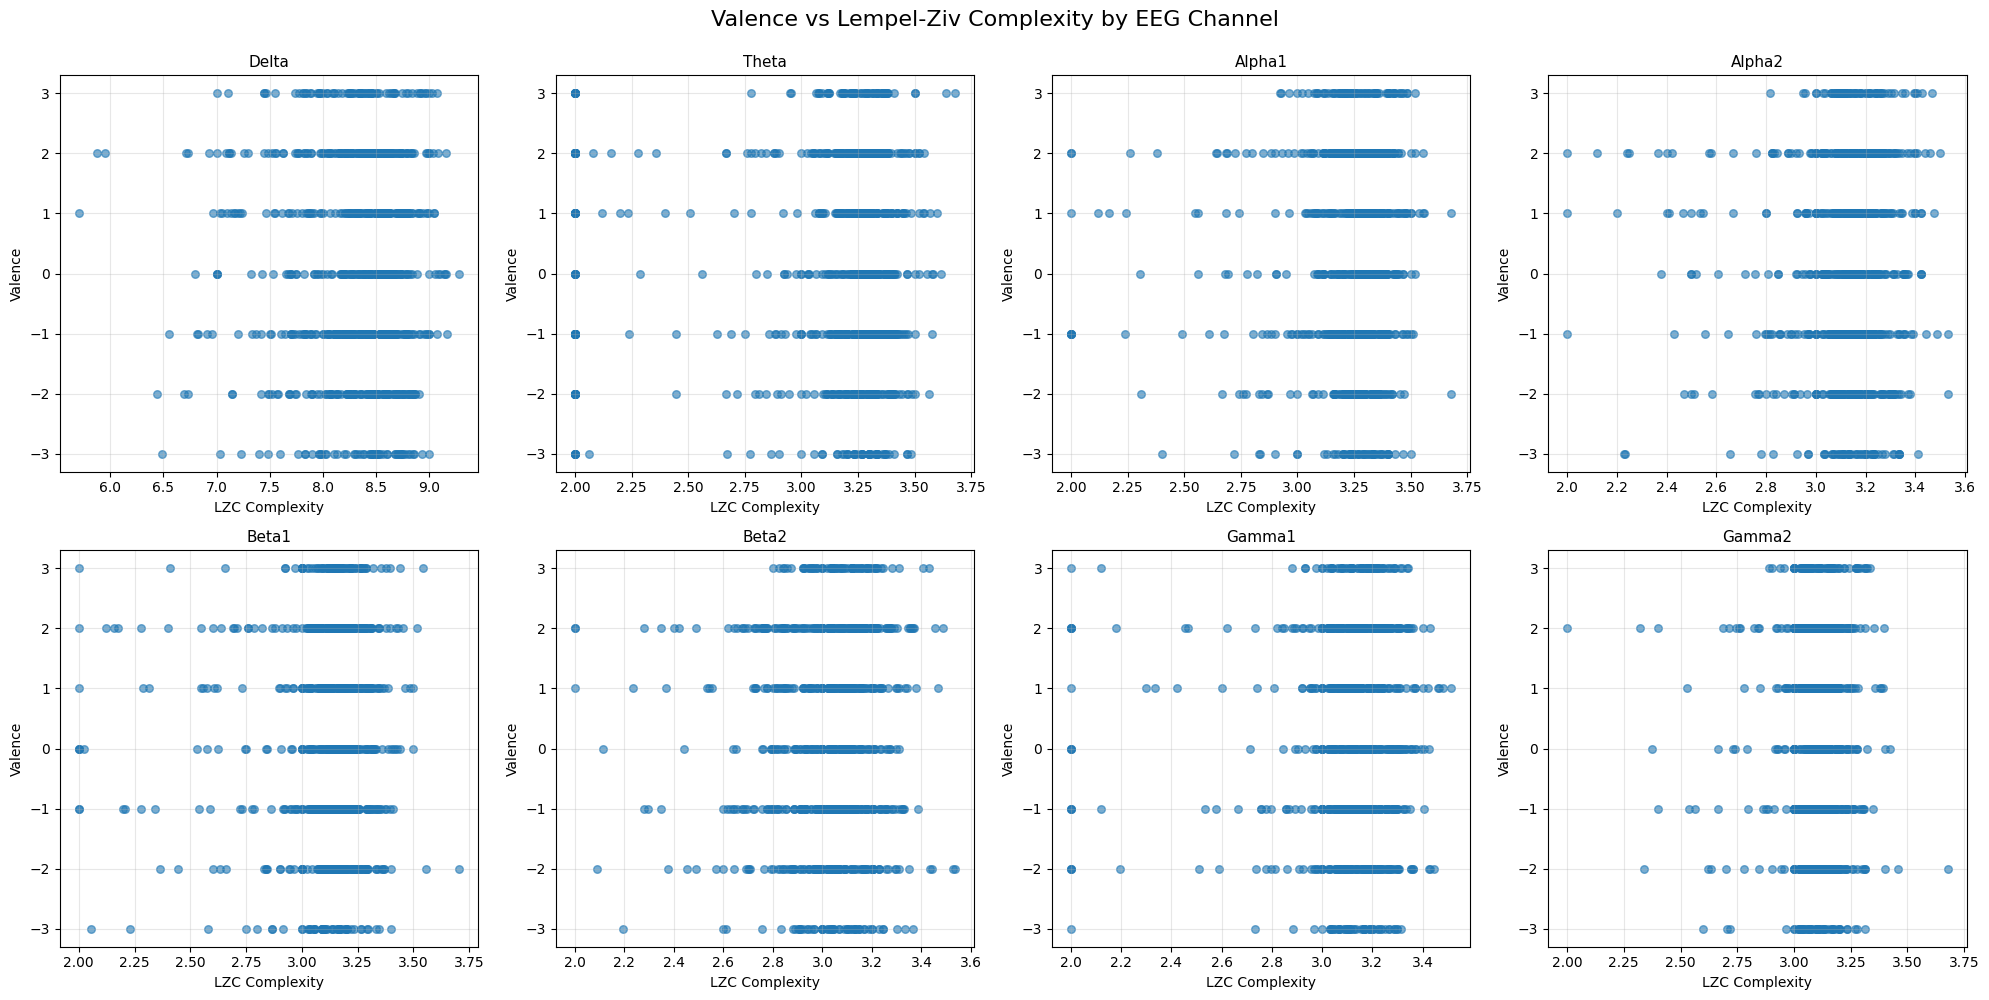

In [67]:
# Create scatter plots for Arousal vs LZC for all 8 channels
# 8 plots total: one for each channel

# Get the channels list
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Create figure with subplots: 2 rows × 4 columns (8 channels)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Valence vs Lempel-Ziv Complexity by EEG Channel', fontsize=16, y=0.995)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# For each channel
for channel_idx, channel_name in enumerate(channels):
    # Extract data for Valence
    lzc_vals = []
    valence_vals = []
    
    # Iterate through all trials (participant × video combinations)
    for participant in lzc_filtered_df_1_to_36.index:
        for video_id in lzc_filtered_df_1_to_36.columns:
            # Get LZC array for this trial
            lzc_array = lzc_filtered_df_1_to_36.at[participant, video_id]
            
            # Skip if None
            if lzc_array is None:
                continue
            
            # Get LZC value for this channel
            if isinstance(lzc_array, np.ndarray) and len(lzc_array) > channel_idx:
                lzc_val = lzc_array[channel_idx]
                
                # Skip if NaN
                if np.isnan(lzc_val):
                    continue
                
                # Get corresponding arousal value from arousal_filtered_df
                if participant in valence_filtered_df.index and video_id in valence_filtered_df.columns:
                    valence_val = valence_filtered_df.at[participant, video_id]
                    if not np.isnan(valence_val):
                        lzc_vals.append(lzc_val)
                        valence_vals.append(valence_val)
    
    # Plot Arousal vs LZC for this channel
    ax = axes_flat[channel_idx]
    ax.scatter(lzc_vals, valence_vals, alpha=0.6, s=30)
    ax.set_xlabel('LZC Complexity', fontsize=10)
    ax.set_ylabel('Valence', fontsize=10)
    ax.set_title(f'{channel_name.capitalize()}', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [68]:
# Create a combined dataframe with all data needed for analysis
# Columns: Participant_ID, Video_ID, Valence, Arousal, and 8 LZC channel scores

# Define channels
channels = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2"]

# Initialize list to store rows
rows = []

# Iterate through all participant/video combinations in lzc_filtered_df_1_to_36
for participant in lzc_filtered_df_1_to_36.index:
    for video_id in lzc_filtered_df_1_to_36.columns:
        # Get LZC array for this trial
        lzc_array = lzc_filtered_df_1_to_36.at[participant, video_id]
        
        # Skip if None
        if lzc_array is None:
            continue
        
        # Initialize row dictionary
        row = {
            'Participant_ID': participant,
            'Video_ID': video_id
        }
        
        # Get Valence from valence_filtered_df
        if participant in valence_filtered_df.index and video_id in valence_filtered_df.columns:
            valence_val = valence_filtered_df.at[participant, video_id]
            row['Valence'] = valence_val if not np.isnan(valence_val) else np.nan
        else:
            row['Valence'] = np.nan
        
        # Get Arousal from arousal_filtered_df
        if participant in arousal_filtered_df.index and video_id in arousal_filtered_df.columns:
            arousal_val = arousal_filtered_df.at[participant, video_id]
            row['Arousal'] = arousal_val if not np.isnan(arousal_val) else np.nan
        else:
            row['Arousal'] = np.nan
        
        # Get LZC scores for each channel
        if isinstance(lzc_array, np.ndarray) and len(lzc_array) == 8:
            for channel_idx, channel_name in enumerate(channels):
                lzc_val = lzc_array[channel_idx]
                row[channel_name] = lzc_val if not np.isnan(lzc_val) else np.nan
        else:
            # If array is not valid, set all channels to NaN
            for channel_name in channels:
                row[channel_name] = np.nan
        
        # Add row to list
        rows.append(row)

# Create DataFrame from list of rows
combined_df = pd.DataFrame(rows)

# Reorder columns: Participant_ID, Video_ID, Valence, Arousal, then 8 channels
column_order = ['Participant_ID', 'Video_ID', 'Valence', 'Arousal'] + channels
combined_df = combined_df[column_order]

print(f"Combined dataframe shape: {combined_df.shape}")
print(f"Columns: {list(combined_df.columns)}")
print(f"\nFirst few rows:")
combined_df


Combined dataframe shape: (865, 12)
Columns: ['Participant_ID', 'Video_ID', 'Valence', 'Arousal', 'delta', 'theta', 'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2']

First few rows:


,Participant_ID,Video_ID,Valence,Arousal,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2
0,1,1,1.0,1.0,8.000000,3.058824,3.117647,3.117647,2.960784,3.117647,3.058824,3.156863
1,1,2,2.0,3.0,8.363636,2.878788,2.848485,3.060606,3.030303,2.757576,3.030303,3.000000
2,1,3,-2.0,1.0,8.666667,3.444444,3.259259,3.148148,3.296296,2.962963,3.185185,3.074074
3,1,5,1.0,4.0,8.900000,3.320000,3.220000,2.800000,2.620000,3.340000,3.140000,3.160000
4,1,7,1.0,3.0,7.177778,2.200000,2.244444,2.466667,2.555556,2.777778,2.422222,2.777778
...,...,...,...,...,...,...,...,...,...,...,...,...
860,36,32,2.0,4.0,8.851852,2.000000,3.259259,3.407407,3.222222,3.370370,3.129630,3.351852
861,36,33,-2.0,5.0,8.620690,2.000000,3.362069,3.293103,2.948276,3.051724,3.051724,3.034483
862,36,34,-3.0,5.0,8.733333,2.000000,3.233333,3.233333,3.266667,3.300000,3.066667,2.600000
863,36,35,-1.0,4.0,8.622222,2.000000,3.266667,3.355556,3.111111,3.133333,2.755556,3.088889


In [69]:
# Create the mean_beta_gamma column as the mean of beta1, beta2, gamma1, and gamma2 for each row (trial)
combined_df['mean_beta_gamma'] = combined_df[['beta1', 'beta2', 'gamma1', 'gamma2']].mean(axis=1)
combined_df['alpha_mean'] = combined_df[['alpha1', 'alpha2']].mean(axis=1)

In [70]:
import statsmodels.formula.api as smf

# Make sure these columns exist as you showed:
# Participant_ID, Video_ID, Arousal, beta1

# Treat arousal as numeric 1–7
combined_df["Arousal"] = combined_df["Arousal"].astype(float)

# Linear mixed model: random intercept for participant, fixed effects for beta1 and Video_ID
model = smf.mixedlm(
    "Arousal ~ beta1 + C(Video_ID)",   # fixed effects
    data=combined_df,
    groups=combined_df["Participant_ID"]        # random intercept for participants
)
result = model.fit()
print(result.summary())

           Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  Arousal   
No. Observations:   865      Method:              REML      
No. Groups:         32       Scale:               1.3414    
Min. group size:    4        Log-Likelihood:      -1381.3061
Max. group size:    36       Converged:           Yes       
Mean group size:    27.0                                    
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          3.342    0.634  5.268 0.000  2.098  4.585
C(Video_ID)[T.2]  -0.251    0.327 -0.768 0.442 -0.892  0.390
C(Video_ID)[T.3]  -0.074    0.323 -0.229 0.819 -0.706  0.559
C(Video_ID)[T.4]   0.285    0.316  0.901 0.367 -0.335  0.904
C(Video_ID)[T.5]   0.661    0.323  2.044 0.041  0.027  1.294
C(Video_ID)[T.6]  -0.205    0.339 -0.604 0.546 -0.869  0.459
C(Video_ID)[T.7]  -0.041    0.326 -0

/Users/danieleybelman/Desktop/EEG_Analysis_Project/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: divide by zero encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/danieleybelman/Desktop/EEG_Analysis_Project/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: overflow encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/Users/danieleybelman/Desktop/EEG_Analysis_Project/.venv/lib/python3.9/site-packages/numpy/linalg/_linalg.py:2311: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)


In [71]:
# Mixed-effects regression for each EEG frequency band
# For each band, fit two models: one predicting Valence and one predicting Arousal
# Each model has: fixed effect for the band, random intercepts for Participant_ID and Video_ID

from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
from IPython.display import display, HTML
warnings.filterwarnings('ignore')

# Define the 8 frequency bands + mean of beta1, beta2, gamma1, and gamma2
bands = ["delta", "theta", "alpha1", "alpha2", "beta1", "beta2", "gamma1", "gamma2", "mean_beta_gamma", "alpha_mean"]

# Store results for all models
results_summary = []

# Loop over all frequency bands
for band in bands:
    print(f"\n{'='*80}")
    print(f"FREQUENCY BAND: {band.upper()}")
    print(f"{'='*80}\n")
    
    # Prepare data for this band - drop rows with missing values for this band and outcome
    # We'll fit two models, so prepare data separately for each
    
    # Model 1: Valence
    print(f"--- Model 1: Predicting Valence from {band} ---")
    data_valence = combined_df[['Participant_ID', 'Video_ID', 'Valence', band]].copy()
    data_valence = data_valence.dropna(subset=['Valence', band])
    
    if len(data_valence) > 0:
        # Fit mixed-effects model with random intercept for Participant_ID
        # Note: For crossed random effects (Participant_ID and Video_ID), 
        # we'll fit separate models for each grouping variable
        # and also create a combined model
        
        # Model with Participant_ID as random effect
        model_valence_participant = MixedLM(
            endog=data_valence['Valence'],
            exog=data_valence[[band]],
            groups=data_valence['Participant_ID']
        )
        result_valence_participant = model_valence_participant.fit()
        
        # Model with Video_ID as random effect
        model_valence_video = MixedLM(
            endog=data_valence['Valence'],
            exog=data_valence[[band]],
            groups=data_valence['Video_ID']
        )
        result_valence_video = model_valence_video.fit()
        
        # Store results
        results_summary.append({
            'Band': band,
            'Outcome': 'Valence',
            'Grouping': 'Participant_ID',
            'Coefficient': result_valence_participant.fe_params[band],
            'SE': result_valence_participant.bse[band],
            'P-value': result_valence_participant.pvalues[band],
            'N': len(data_valence),
            'AIC': result_valence_participant.aic,
            'BIC': result_valence_participant.bic
        })
        
        results_summary.append({
            'Band': band,
            'Outcome': 'Valence',
            'Grouping': 'Video_ID',
            'Coefficient': result_valence_video.fe_params[band],
            'SE': result_valence_video.bse[band],
            'P-value': result_valence_video.pvalues[band],
            'N': len(data_valence),
            'AIC': result_valence_video.aic,
            'BIC': result_valence_video.bic
        })
        
        # Print fixed-effect summary for Participant_ID model
        print(f"\nFixed Effects (Random Intercept: Participant_ID):")
        print(result_valence_participant.summary().tables[1])
        
        # Print fixed-effect summary for Video_ID model
        print(f"\nFixed Effects (Random Intercept: Video_ID):")
        print(result_valence_video.summary().tables[1])
    else:
        print("Insufficient data for Valence model")
    
    # Model 2: Arousal
    print(f"\n--- Model 2: Predicting Arousal from {band} ---")
    data_arousal = combined_df[['Participant_ID', 'Video_ID', 'Arousal', band]].copy()
    data_arousal = data_arousal.dropna(subset=['Arousal', band])
    
    if len(data_arousal) > 0:
        # Model with Participant_ID as random effect
        model_arousal_participant = MixedLM(
            endog=data_arousal['Arousal'],
            exog=data_arousal[[band]],
            groups=data_arousal['Participant_ID']
        )
        result_arousal_participant = model_arousal_participant.fit()
        
        # Model with Video_ID as random effect
        model_arousal_video = MixedLM(
            endog=data_arousal['Arousal'],
            exog=data_arousal[[band]],
            groups=data_arousal['Video_ID']
        )
        result_arousal_video = model_arousal_video.fit()
        
        # Store results
        results_summary.append({
            'Band': band,
            'Outcome': 'Arousal',
            'Grouping': 'Participant_ID',
            'Coefficient': result_arousal_participant.fe_params[band],
            'SE': result_arousal_participant.bse[band],
            'P-value': result_arousal_participant.pvalues[band],
            'N': len(data_arousal),
            'AIC': result_arousal_participant.aic,
            'BIC': result_arousal_participant.bic
        })
        
        results_summary.append({
            'Band': band,
            'Outcome': 'Arousal',
            'Grouping': 'Video_ID',
            'Coefficient': result_arousal_video.fe_params[band],
            'SE': result_arousal_video.bse[band],
            'P-value': result_arousal_video.pvalues[band],
            'N': len(data_arousal),
            'AIC': result_arousal_video.aic,
            'BIC': result_arousal_video.bic
        })
        
        # # Print fixed-effect summary for Participant_ID model
        # print(f"\nFixed Effects (Random Intercept: Participant_ID):")
        # print(result_arousal_participant.summary().tables[1])
        
        # # Print fixed-effect summary for Video_ID model
        # print(f"\nFixed Effects (Random Intercept: Video_ID):")
        # print(result_arousal_video.summary().tables[1])

        # In your loop, instead of print(), use:
        display(HTML(f"<h3>Band: {band.upper()}, Outcome: Valence, Grouping: Participant_ID</h3>"))
        display(result_valence_participant.summary())
    else:
        print("Insufficient data for Arousal model")

# Create summary DataFrame
results_df = pd.DataFrame(results_summary)

print(f"\n\n{'='*80}")
print("SUMMARY OF ALL MODELS")
print(f"{'='*80}\n")

# Use display() instead of print() for DataFrames to avoid truncation
display(results_df)


FREQUENCY BAND: DELTA

--- Model 1: Predicting Valence from delta ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
delta      0.015    0.009  1.632  0.103  -0.003  0.033
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
delta      0.019    0.027  0.716  0.474  -0.033  0.072
Group Var  1.988    0.465                             

--- Model 2: Predicting Arousal from delta ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0051    
Min. group size:  4       Log-Likelihood:     -1713.7090
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
delta       0.015     0.009  1.632  0.103  -0.003   0.033
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: THETA

--- Model 1: Predicting Valence from theta ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
theta      0.040    0.024  1.647  0.099  -0.008  0.087
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
theta      0.006    0.059  0.105  0.916  -0.109  0.121
Group Var  1.982    0.462                             

--- Model 2: Predicting Arousal from theta ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0046    
Min. group size:  4       Log-Likelihood:     -1712.7076
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
theta       0.040     0.024  1.647  0.099  -0.008   0.087
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: ALPHA1

--- Model 1: Predicting Valence from alpha1 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha1     0.040    0.024  1.681  0.093  -0.007  0.086
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha1     0.005    0.068  0.075  0.940  -0.128  0.138
Group Var  1.996    0.469                             

--- Model 2: Predicting Arousal from alpha1 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0045    
Min. group size:  4       Log-Likelihood:     -1712.6811
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
alpha1      0.040     0.024  1.681  0.093  -0.007   0.086
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: ALPHA2

--- Model 1: Predicting Valence from alpha2 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha2     0.042    0.024  1.711  0.087  -0.006  0.089
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha2     0.046    0.071  0.644  0.520  -0.093  0.184
Group Var  1.985    0.464                             

--- Model 2: Predicting Arousal from alpha2 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0044    
Min. group size:  4       Log-Likelihood:     -1712.5991
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
alpha2      0.042     0.024  1.711  0.087  -0.006   0.089
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: BETA1

--- Model 1: Predicting Valence from beta1 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta1      0.041    0.024  1.689  0.091  -0.007  0.089
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta1      0.036    0.069  0.520  0.603  -0.100  0.172
Group Var  1.983    0.463                             

--- Model 2: Predicting Arousal from beta1 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0046    
Min. group size:  4       Log-Likelihood:     -1712.6357
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
beta1       0.041     0.024  1.689  0.091  -0.007   0.089
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: BETA2

--- Model 1: Predicting Valence from beta2 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta2      0.042    0.025  1.685  0.092  -0.007  0.091
Group Var  0.063    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
beta2      0.087    0.073  1.190  0.234  -0.057  0.231
Group Var  2.005    0.473                             

--- Model 2: Predicting Arousal from beta2 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0054    
Min. group size:  4       Log-Likelihood:     -1712.6236
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
beta2       0.042     0.025  1.685  0.092  -0.007   0.091
Group Var   0.063     0.025                              
========================================================

"""


FREQUENCY BAND: GAMMA1

--- Model 1: Predicting Valence from gamma1 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma1     0.041    0.024  1.689  0.091  -0.007  0.089
Group Var  0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma1     0.037    0.070  0.532  0.595  -0.100  0.174
Group Var  1.983    0.463                             

--- Model 2: Predicting Arousal from gamma1 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0046    
Min. group size:  4       Log-Likelihood:     -1712.6322
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
gamma1      0.041     0.024  1.689  0.091  -0.007   0.089
Group Var   0.065     0.025                              
========================================================

"""


FREQUENCY BAND: GAMMA2

--- Model 1: Predicting Valence from gamma2 ---

Fixed Effects (Random Intercept: Participant_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma2     0.041    0.024  1.663  0.096  -0.007  0.089
Group Var  0.064    0.025                             

Fixed Effects (Random Intercept: Video_ID):
           Coef. Std.Err.      z  P>|z|  [0.025 0.975]
gamma2     0.048    0.074  0.645  0.519  -0.098  0.193
Group Var  1.990    0.466                             

--- Model 2: Predicting Arousal from gamma2 ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0051    
Min. group size:  4       Log-Likelihood:     -1712.6757
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
gamma2      0.041     0.024  1.663  0.096  -0.007   0.089
Group Var   0.064     0.025                              
========================================================

"""


FREQUENCY BAND: MEAN_BETA_GAMMA

--- Model 1: Predicting Valence from mean_beta_gamma ---

Fixed Effects (Random Intercept: Participant_ID):
                 Coef. Std.Err.      z  P>|z|  [0.025 0.975]
mean_beta_gamma  0.041    0.025  1.684  0.092  -0.007  0.089
Group Var        0.064    0.025                             

Fixed Effects (Random Intercept: Video_ID):
                 Coef. Std.Err.      z  P>|z|  [0.025 0.975]
mean_beta_gamma  0.055    0.074  0.746  0.456  -0.090  0.201
Group Var        1.991    0.467                             

--- Model 2: Predicting Arousal from mean_beta_gamma ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0049    
Min. group size:  4       Log-Likelihood:     -1712.6360
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
--------------------------------------------------------
                Coef. Std.Err.   z   P>|z| [0.025 0.975]
--------------------------------------------------------
mean_beta_gamma 0.041    0.025 1.684 0.092 -0.007  0.089
Group Var       0.064    0.025                          
========================================================

"""


FREQUENCY BAND: ALPHA_MEAN

--- Model 1: Predicting Valence from alpha_mean ---

Fixed Effects (Random Intercept: Participant_ID):
            Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha_mean  0.041    0.024  1.698  0.090  -0.006  0.088
Group Var   0.065    0.025                             

Fixed Effects (Random Intercept: Video_ID):
            Coef. Std.Err.      z  P>|z|  [0.025 0.975]
alpha_mean  0.026    0.071  0.362  0.717  -0.113  0.165
Group Var   1.989    0.466                             

--- Model 2: Predicting Arousal from alpha_mean ---


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: Valence   
No. Observations: 865     Method:             REML      
No. Groups:       32      Scale:              3.0044    
Min. group size:  4       Log-Likelihood:     -1712.6365
Max. group size:  36      Converged:          Yes       
Mean group size:  27.0                                  
---------------------------------------------------------
            Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
---------------------------------------------------------
alpha_mean  0.041     0.024  1.698  0.090  -0.006   0.088
Group Var   0.065     0.025                              
========================================================

"""



SUMMARY OF ALL MODELS



,Band,Outcome,Grouping,Coefficient,SE,P-value,N,AIC,BIC
0,delta,Valence,Participant_ID,0.014892,0.009125,1.026836e-01,865,NaN,NaN
1,delta,Valence,Video_ID,0.019202,0.026801,4.737130e-01,865,NaN,NaN
2,delta,Arousal,Participant_ID,0.448550,0.012203,9.293750e-296,865,NaN,NaN
3,delta,Arousal,Video_ID,0.444141,0.010843,0.000000e+00,865,NaN,NaN
4,theta,Valence,Participant_ID,0.039794,0.024155,9.946908e-02,865,NaN,NaN
5,theta,Valence,Video_ID,0.006187,0.058751,9.161304e-01,865,NaN,NaN
6,theta,Arousal,Participant_ID,1.157558,0.039061,5.299832e-193,865,NaN,NaN
7,theta,Arousal,Video_ID,1.106501,0.041835,3.745014e-154,865,NaN,NaN
8,alpha1,Valence,Participant_ID,0.039532,0.023520,9.280890e-02,865,NaN,NaN
9,alpha1,Valence,Video_ID,0.005103,0.068007,9.401798e-01,865,NaN,NaN


In [72]:
import statsmodels.formula.api as smf

bands = ["delta", "theta", "alpha1", "alpha2",
            "beta1", "beta2", "gamma1", "gamma2",
            "mean_beta_gamma", "alpha_mean"]

outcomes = ["Valence", "Arousal"]

results = []

for band in bands:
    for outcome in outcomes:
        # Keep only the columns we need for this model
        model_df = combined_df[["Participant_ID", "Video_ID", outcome, band]].copy()
        model_df = model_df.dropna(subset=[outcome, band])
        
        if model_df.empty:
            continue
        
        # Formula: Outcome ~ band + C(Video_ID)
        formula = f"{outcome} ~ {band} + C(Video_ID)"
        
        # Mixed model: random intercept for Participant_ID
        model = smf.mixedlm(formula, data=model_df, groups=model_df["Participant_ID"])
        result = model.fit(reml=False)  # reml=True is default; OK for comparing effects
        
        # Extract the band coefficient info
        coef = result.params[band]
        se = result.bse[band]
        p = result.pvalues[band]
        
        # Store in results list
        results.append({
            "Band": band,
            "Outcome": outcome,
            "Grouping": "Participant_ID (random) + Video_ID (fixed)",
            "Coefficient": coef,
            "SE": se,
            "P-value": p,
            "N": len(model_df),
            "AIC": result.aic,
            "BIC": result.bic
        })

# Turn into a nice summary DataFrame
results_df = pd.DataFrame(results)

# Optional: sort for readability
results_df = results_df.sort_values(by=["Outcome", "Band"]).reset_index(drop=True)

results_df

,Band,Outcome,Grouping,Coefficient,SE,P-value,N,AIC,BIC
0,alpha1,Arousal,Participant_ID (random) + Video_ID (fixed),0.004364,0.199172,0.982519,865,2803.863294,2989.609744
1,alpha2,Arousal,Participant_ID (random) + Video_ID (fixed),0.117303,0.220503,0.594740,865,2803.580817,2989.327268
2,alpha_mean,Arousal,Participant_ID (random) + Video_ID (fixed),0.084560,0.258948,0.744006,865,2803.757144,2989.503595
3,beta1,Arousal,Participant_ID (random) + Video_ID (fixed),0.200630,0.190783,0.292979,865,2802.758199,2988.504650
4,beta2,Arousal,Participant_ID (random) + Video_ID (fixed),0.003862,0.225971,0.986364,865,2803.863481,2989.609932
5,delta,Arousal,Participant_ID (random) + Video_ID (fixed),0.017838,0.095623,0.852017,865,2803.828974,2989.575425
6,gamma1,Arousal,Participant_ID (random) + Video_ID (fixed),0.223531,0.212644,0.293167,865,2802.757334,2988.503785
7,gamma2,Arousal,Participant_ID (random) + Video_ID (fixed),0.088246,0.320838,0.783279,865,2803.788124,2989.534575
8,mean_beta_gamma,Arousal,Participant_ID (random) + Video_ID (fixed),0.302587,0.325876,0.353130,865,2803.001703,2988.748154
9,theta,Arousal,Participant_ID (random) + Video_ID (fixed),-0.094697,0.172308,0.582607,865,2803.561299,2989.307750


In [73]:
# Make a copy if you like, but this is fine in-place:
combined_df["Arousal_binary"] = np.where(
    combined_df["Arousal"].between(1, 4), 0,
    np.where(combined_df["Arousal"].between(5, 7), 1, np.nan)
)

In [76]:
import statsmodels.api as sm

bands = ["delta", "theta", "alpha1", "alpha2",
         "beta1", "beta2", "gamma1", "gamma2",
         "mean_beta_gamma", "alpha_mean"]

logit_results = []

for band in bands:
    # Keep only the columns we need
    model_df = combined_df[["Participant_ID", "Video_ID", "Arousal_binary", band]].copy()
    model_df = model_df.dropna(subset=["Arousal_binary", band])

    if model_df.empty:
        continue

    # Logistic regression with fixed effect of Video_ID
    formula = f"Arousal_binary ~ {band} + C(Video_ID)"

    logit_model = smf.glm(
        formula,
        data=model_df,
        family=sm.families.Binomial()
    )

    # Cluster-robust SEs by Participant
    logit_result = logit_model.fit(
        cov_type="cluster",
        cov_kwds={"groups": model_df["Participant_ID"]}
    )

    coef = logit_result.params[band]
    se = logit_result.bse[band]
    p = logit_result.pvalues[band]
    aic = logit_result.aic
    bic = logit_result.bic
    converge = logit_result.converged

    # Odds ratio for interpretability
    odds_ratio = np.exp(coef)

    logit_results.append({
        "Band": band,
        "Outcome": "Arousal_binary",
        "Model": "Logistic GLM + C(Video_ID), clustered by Participant_ID",
        "Coefficient (log-odds)": coef,
        "SE": se,
        "P-value": p,
        "Odds Ratio": odds_ratio,
        "N": len(model_df),
        "AIC": aic,
        "BIC": bic,
        "Converged": converge
    })

logit_results_df = pd.DataFrame(logit_results)
logit_results_df = logit_results_df.sort_values(by="Band").reset_index(drop=True)

logit_results_df

,Band,Outcome,Model,Coefficient (log-odds),SE,P-value,Odds Ratio,N,AIC,BIC,Converged
0,alpha1,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",-0.101835,0.328282,0.756403,0.903178,856,1030.759574,-4573.349864,True
1,alpha2,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.896402,0.562442,0.110988,2.450770,856,1026.494802,-4577.614636,True
2,alpha_mean,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.482506,0.522358,0.355639,1.620129,856,1029.839100,-4574.270338,True
3,beta1,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.481872,0.466023,0.301132,1.619103,856,1029.157430,-4574.952008,True
4,beta2,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.639265,0.592609,0.280709,1.895087,856,1028.653105,-4575.456334,True
5,delta,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.056114,0.238860,0.814268,1.057718,856,1030.729162,-4573.380276,True
6,gamma1,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.104499,0.508482,0.837173,1.110154,856,1030.762104,-4573.347334,True
7,gamma2,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.518958,0.595690,0.383651,1.680276,856,1030.185565,-4573.923873,True
8,mean_beta_gamma,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",0.818378,0.809584,0.312082,2.266820,856,1029.016037,-4575.093401,True
9,theta,Arousal_binary,"Logistic GLM + C(Video_ID), clustered by Parti...",-0.120763,0.259572,0.641760,0.886244,856,1030.464902,-4573.644536,True


In [ ]:
# Aggregation dictionary for all target columns
agg_dict = {
    "Arousal": lambda x: np.nan,  # placeholder, will fill below
    "Valence": lambda x: np.nan,
    "Participant_ID": "nunique",  # how many people rated each video
}
for band in bands:
    agg_dict[band] = lambda x: np.nan

def remove_outliers_and_mean(series, z_thresh=2.5):
    vals = series.dropna()
    if len(vals) == 0:
        return np.nan
    z = np.abs((vals - vals.mean()) / vals.std(ddof=0))
    filtered = vals[z <= z_thresh]
    if len(filtered) == 0:
        return np.nan
    return filtered.mean()

agg_dict["Arousal"] = remove_outliers_and_mean
agg_dict["Valence"] = remove_outliers_and_mean
for band in bands:
    agg_dict[band] = remove_outliers_and_mean

combined_per_video_df = combined_df.groupby("Video_ID").agg(agg_dict).reset_index()

# Rename columns for clarity
combined_per_video_df = combined_per_video_df.rename(columns={
    "Arousal": "Arousal_mean",
    "Valence": "Valence_mean",
    "Participant_ID": "N_participants"
})

combined_per_video_df

,Video_ID,Arousal_mean,Valence_mean,N_participants,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,mean_beta_gamma,alpha_mean
0,1,4.038462,1.814815,27,8.290347,3.134902,3.199849,3.107843,3.097255,3.045249,3.123366,3.096531,3.078431,3.180784
1,2,3.708333,1.291667,24,8.446970,3.304408,3.305665,3.184453,3.198946,3.117260,3.198232,3.132576,3.152146,3.233202
2,3,3.880000,1.080000,25,8.307099,3.260870,3.231481,3.168210,3.141975,3.034074,3.188406,3.121914,3.110340,3.193673
3,4,4.384615,1.461538,27,8.183150,3.215238,3.270147,3.146520,3.110806,3.052910,3.102564,3.119963,3.114286,3.208333
4,5,4.600000,1.720000,25,8.288333,3.224348,3.246667,3.108333,3.118333,3.030833,3.131667,3.100833,3.095417,3.177500
5,6,3.761905,1.571429,21,8.457490,3.283401,3.291209,3.113553,3.128205,2.994231,3.135531,3.080586,3.085096,3.191346
6,7,4.000000,1.291667,24,8.201852,3.062963,3.186473,3.101449,3.026852,3.025000,3.121739,3.069444,3.053472,3.169697
7,8,4.000000,2.157895,20,8.442424,3.260943,3.278788,3.175439,3.175439,3.042424,3.167464,3.111643,3.101515,3.224083
8,9,4.217391,1.260870,23,8.423377,3.228571,3.228571,3.137662,3.177922,3.053416,3.183851,3.125974,3.127329,3.190062
9,10,2.750000,1.083333,24,8.431884,3.219192,3.281159,3.145370,3.159420,3.028704,3.138889,3.109179,3.114493,3.218841


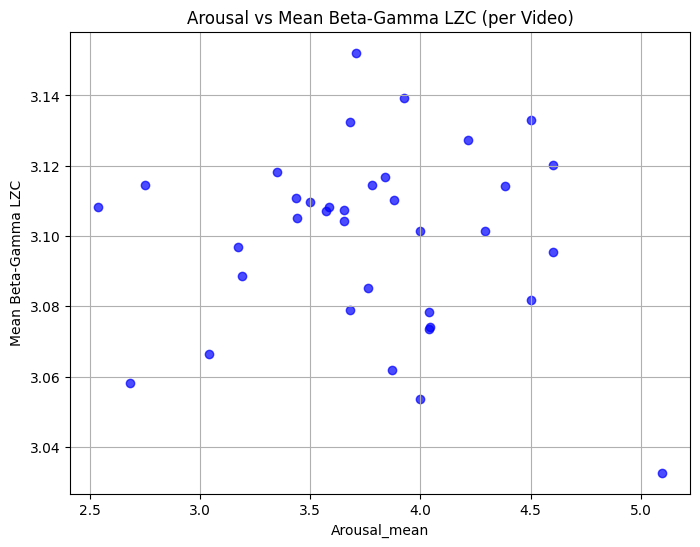

Linear regression: mean_beta_gamma ~ Arousal_mean
Coefficient: -0.0037
Intercept: 3.1133
R^2: 0.0063
MSE: 0.0006
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2148
Date:                Tue, 02 Dec 2025   Prob (F-statistic):              0.646
Time:                        16:53:15   Log-Likelihood:                 81.138
No. Observations:                  36   AIC:                            -158.3
Df Residuals:                      34   BIC:                            -155.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(combined_per_video_df["Arousal_mean"], combined_per_video_df["mean_beta_gamma"], c='blue', alpha=0.7)
plt.xlabel("Arousal_mean")
plt.ylabel("Mean Beta-Gamma LZC")
plt.title("Arousal vs Mean Beta-Gamma LZC (per Video)")
plt.grid(True)
plt.show()
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Prepare variables for regression
X = combined_per_video_df[["Arousal_mean"]].values
y = combined_per_video_df["mean_beta_gamma"].values

# Fit linear regression
reg = LinearRegression()
reg.fit(X, y)
y_pred = reg.predict(X)

# Calculate statistics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
coef = reg.coef_[0]
intercept = reg.intercept_

# Print regression statistics
print("Linear regression: mean_beta_gamma ~ Arousal_mean")
print(f"Coefficient: {coef:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"R^2: {r2:.4f}")
print(f"MSE: {mse:.4f}")

# If you want more detailed stats, use statsmodels
import statsmodels.api as sm
X_sm = sm.add_constant(X)
model = sm.OLS(y, X_sm)
results = model.fit()
print(results.summary())


In [ ]:
from scipy.stats import pearsonr

corr_results = []

for band in bands:
    # Now: Predict lzc from arousal/valence, i.e., lzc ~ arousal_mean
    r, p = pearsonr(combined_per_video_df["Arousal_mean"], combined_per_video_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Arousal_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

for band in bands:
    r, p = pearsonr(combined_per_video_df["Valence_mean"], combined_per_video_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Valence_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

corr_df = pd.DataFrame(corr_results)
corr_df

,Band,Predictor,Outcome,Pearson_r,P_value
0,delta,Arousal_mean,delta,-0.128213,0.456143
1,theta,Arousal_mean,theta,-0.080942,0.638866
2,alpha1,Arousal_mean,alpha1,-0.308595,0.067069
3,alpha2,Arousal_mean,alpha2,-0.367732,0.027350
4,beta1,Arousal_mean,beta1,-0.106601,0.536046
5,beta2,Arousal_mean,beta2,-0.103605,0.547633
6,gamma1,Arousal_mean,gamma1,-0.106728,0.535559
7,gamma2,Arousal_mean,gamma2,-0.105657,0.539683
8,mean_beta_gamma,Arousal_mean,mean_beta_gamma,-0.079227,0.646010
9,alpha_mean,Arousal_mean,alpha_mean,-0.564387,0.000337


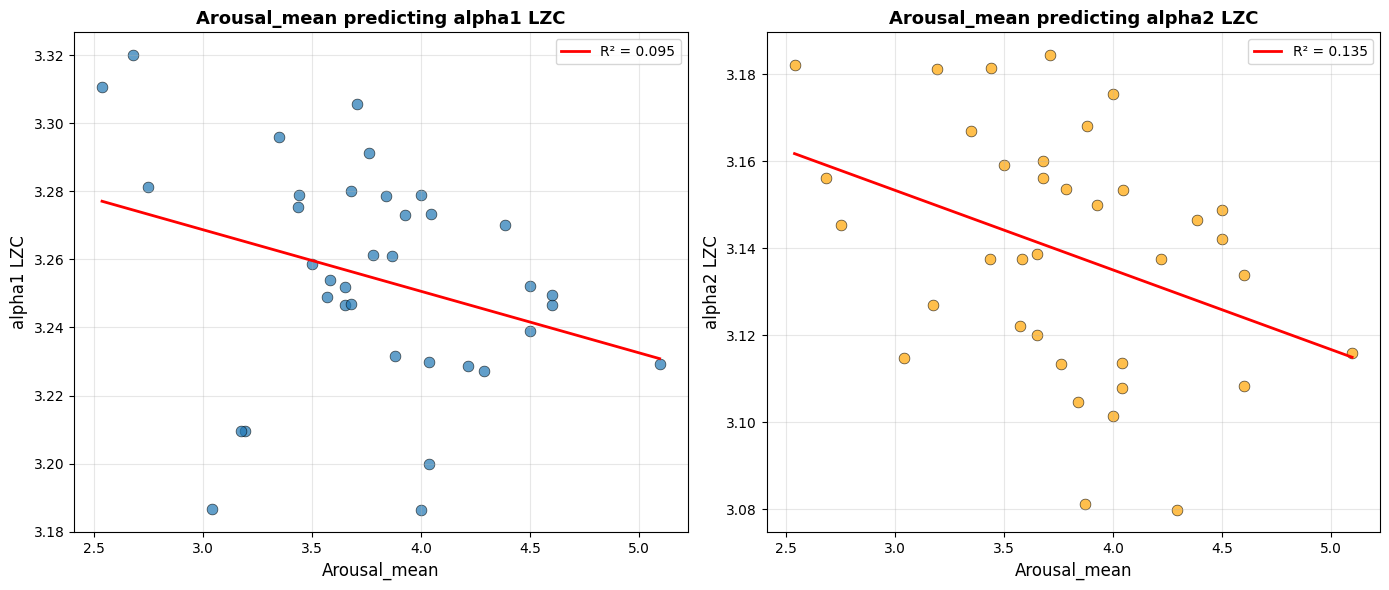

Regression Statistics:

Arousal_mean predicting alpha1:
  Coefficient: -0.0181
  Intercept: 3.3230
  R²: 0.0952
  N: 36

Arousal_mean predicting alpha2:
  Coefficient: -0.0183
  Intercept: 3.2083
  R²: 0.1352
  N: 36


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Create figure with 2 subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Arousal_mean predicting alpha1
ax1 = axes[0]
x1 = combined_per_video_df["Arousal_mean"].values  # Independent variable
y1 = combined_per_video_df["alpha1"].values  # Dependent variable

# Remove NaN values
mask1 = ~(np.isnan(x1) | np.isnan(y1))
x1_clean = x1[mask1]
y1_clean = y1[mask1]

# Scatter plot
ax1.scatter(x1_clean, y1_clean, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)

# Fit regression line (predicting alpha1 from Arousal_mean)
if len(x1_clean) > 0:
    reg1 = LinearRegression()
    reg1.fit(x1_clean.reshape(-1, 1), y1_clean)
    y1_pred = reg1.predict(x1_clean.reshape(-1, 1))
    
    # Sort for plotting regression line smoothly
    sort_idx = np.argsort(x1_clean)
    x1_sorted = x1_clean[sort_idx]
    y1_pred_sorted = y1_pred[sort_idx]
    
    # Plot regression line
    ax1.plot(x1_sorted, y1_pred_sorted, 'r-', linewidth=2, label=f'R² = {reg1.score(x1_clean.reshape(-1, 1), y1_clean):.3f}')
    ax1.legend()

ax1.set_xlabel('Arousal_mean', fontsize=12)
ax1.set_ylabel('alpha1 LZC', fontsize=12)
ax1.set_title('Arousal_mean predicting alpha1 LZC', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Arousal_mean predicting alpha2
ax2 = axes[1]
x2 = combined_per_video_df["Arousal_mean"].values  # Independent variable
y2 = combined_per_video_df["alpha2"].values  # Dependent variable

# Remove NaN values
mask2 = ~(np.isnan(x2) | np.isnan(y2))
x2_clean = x2[mask2]
y2_clean = y2[mask2]

# Scatter plot
ax2.scatter(x2_clean, y2_clean, alpha=0.7, s=60, edgecolors='black', linewidth=0.5, color='orange')

# Fit regression line (predicting alpha2 from Arousal_mean)
if len(x2_clean) > 0:
    reg2 = LinearRegression()
    reg2.fit(x2_clean.reshape(-1, 1), y2_clean)
    y2_pred = reg2.predict(x2_clean.reshape(-1, 1))
    
    # Sort for plotting regression line smoothly
    sort_idx = np.argsort(x2_clean)
    x2_sorted = x2_clean[sort_idx]
    y2_pred_sorted = y2_pred[sort_idx]
    
    # Plot regression line
    ax2.plot(x2_sorted, y2_pred_sorted, 'r-', linewidth=2, label=f'R² = {reg2.score(x2_clean.reshape(-1, 1), y2_clean):.3f}')
    ax2.legend()

ax2.set_xlabel('Arousal_mean', fontsize=12)
ax2.set_ylabel('alpha2 LZC', fontsize=12)
ax2.set_title('Arousal_mean predicting alpha2 LZC', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print regression statistics
print("Regression Statistics:")
print("="*60)
print(f"\nArousal_mean predicting alpha1:")
if len(x1_clean) > 0:
    print(f"  Coefficient: {reg1.coef_[0]:.4f}")
    print(f"  Intercept: {reg1.intercept_:.4f}")
    print(f"  R²: {reg1.score(x1_clean.reshape(-1, 1), y1_clean):.4f}")
    print(f"  N: {len(x1_clean)}")

print(f"\nArousal_mean predicting alpha2:")
if len(x2_clean) > 0:
    print(f"  Coefficient: {reg2.coef_[0]:.4f}")
    print(f"  Intercept: {reg2.intercept_:.4f}")
    print(f"  R²: {reg2.score(x2_clean.reshape(-1, 1), y2_clean):.4f}")
    print(f"  N: {len(x2_clean)}")


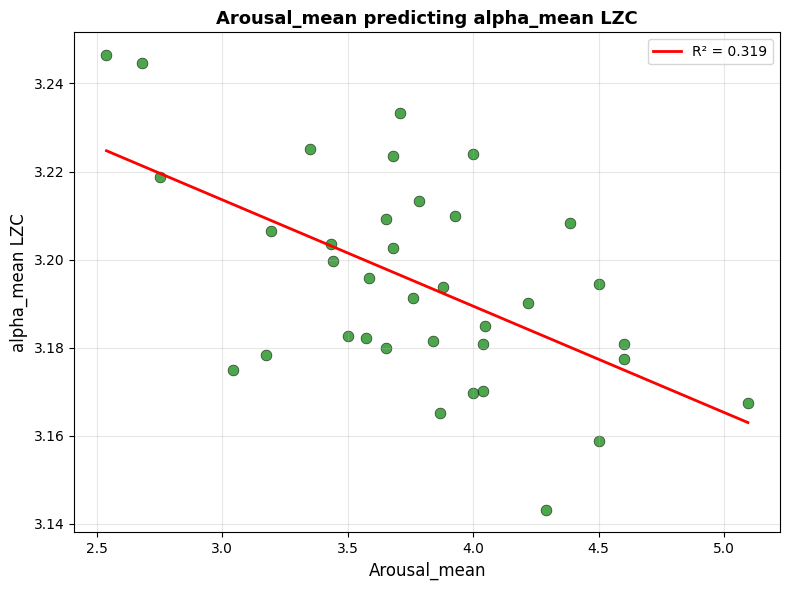

Regression Statistics:

Arousal_mean predicting alpha_mean:
  Coefficient: -0.0242
  Intercept: 3.2860
  R²: 0.3185
  N: 36


In [ ]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Calculate alpha_mean if it doesn't exist in combined_per_video_df
if 'alpha_mean' not in combined_per_video_df.columns:
    combined_per_video_df['alpha_mean'] = combined_per_video_df[['alpha1', 'alpha2']].mean(axis=1)

# Create scatter plot for alpha_mean
plt.figure(figsize=(8, 6))

# Arousal_mean predicting alpha_mean
x = combined_per_video_df["Arousal_mean"].values  # Independent variable
y = combined_per_video_df["alpha_mean"].values  # Dependent variable

# Remove NaN values
mask = ~(np.isnan(x) | np.isnan(y))
x_clean = x[mask]
y_clean = y[mask]

# Scatter plot
plt.scatter(x_clean, y_clean, alpha=0.7, s=60, edgecolors='black', linewidth=0.5, color='green')

# Fit regression line (predicting alpha_mean from Arousal_mean)
if len(x_clean) > 0:
    reg = LinearRegression()
    reg.fit(x_clean.reshape(-1, 1), y_clean)
    y_pred = reg.predict(x_clean.reshape(-1, 1))
    
    # Sort for plotting regression line smoothly
    sort_idx = np.argsort(x_clean)
    x_sorted = x_clean[sort_idx]
    y_pred_sorted = y_pred[sort_idx]
    
    # Plot regression line
    plt.plot(x_sorted, y_pred_sorted, 'r-', linewidth=2, label=f'R² = {reg.score(x_clean.reshape(-1, 1), y_clean):.3f}')
    plt.legend()

plt.xlabel('Arousal_mean', fontsize=12)
plt.ylabel('alpha_mean LZC', fontsize=12)
plt.title('Arousal_mean predicting alpha_mean LZC', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print regression statistics
print("Regression Statistics:")
print("="*60)
print(f"\nArousal_mean predicting alpha_mean:")
if len(x_clean) > 0:
    print(f"  Coefficient: {reg.coef_[0]:.4f}")
    print(f"  Intercept: {reg.intercept_:.4f}")
    print(f"  R²: {reg.score(x_clean.reshape(-1, 1), y_clean):.4f}")
    print(f"  N: {len(x_clean)}")


Columns in combined_df:
Index(['Participant_ID', 'Video_ID', 'Valence', 'Arousal', 'delta', 'theta',
       'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma1', 'gamma2',
       'mean_beta_gamma', 'alpha_mean'],
      dtype='object')

Rows after dropping NaNs: 865
  Participant_ID  Video_ID  Arousal  alpha_mean
0              1         1      1.0    3.117647
1              1         2      3.0    2.954545
2              1         3      1.0    3.203704
3              1         5      4.0    3.010000
4              1         7      3.0    2.355556

Example of z-scored data:
  Participant_ID  Video_ID  Arousal  alpha_mean  Arousal_z  alpha_mean_z
0              1         1      1.0    3.117647  -1.289652      0.315369
1              1         2      3.0    2.954545   0.064483     -0.324629
2              1         3      1.0    3.203704  -1.289652      0.653048
3              1         5      4.0    3.010000   0.741550     -0.107030
4              1         7      3.0    2.355556   0.064483  

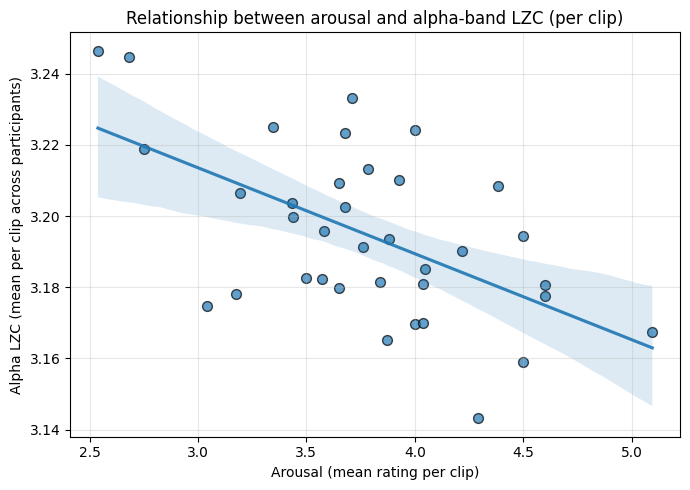

In [ ]:
# -------------------------------------------------------------------
# 0. Assumption: you already have `combined_df`
#    with columns:
#    ['Participant_ID', 'Video_ID', 'Arousal',
#     'delta','theta','alpha1','alpha2','beta1','beta2','gamma1','gamma2', ...]
# -------------------------------------------------------------------

print("Columns in combined_df:")
print(combined_df.columns)

# -------------------------------------------------------------------
# 1. Create a single alpha measure (mean of alpha1 and alpha2)
# -------------------------------------------------------------------
combined_df["alpha_mean"] = combined_df[["alpha1", "alpha2"]].mean(axis=1)

# Keep only the columns needed for this analysis
model_df = combined_df[["Participant_ID", "Video_ID", "Arousal", "alpha_mean"]].copy()

# Drop rows with missing Arousal or alpha_mean
model_df = model_df.dropna(subset=["Arousal", "alpha_mean"])

print(f"\nRows after dropping NaNs: {len(model_df)}")
print(model_df.head())

# -------------------------------------------------------------------
# 2. Within-participant z-scoring for Arousal and alpha_mean
#    This makes the effect "within-person": deviations from each
#    participant's own average.
# -------------------------------------------------------------------
grouped = model_df.groupby("Participant_ID")

model_df["Arousal_z"] = grouped["Arousal"].transform(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)
model_df["alpha_mean_z"] = grouped["alpha_mean"].transform(
    lambda x: (x - x.mean()) / (x.std(ddof=0) + 1e-9)
)

print("\nExample of z-scored data:")
print(model_df[["Participant_ID", "Video_ID", "Arousal", "alpha_mean",
                "Arousal_z", "alpha_mean_z"]].head())

# -------------------------------------------------------------------
# 3. Mixed model:
#    Arousal_z ~ alpha_mean_z + fixed effect of Video_ID
#    Random intercept per Participant_ID
# -------------------------------------------------------------------
formula = "Arousal_z ~ alpha_mean_z + C(Video_ID)"

alpha_model = smf.mixedlm(
    formula,
    data=model_df,
    groups=model_df["Participant_ID"]  # random intercept for participants
)
alpha_result = alpha_model.fit(reml=True)

print("\n=== Mixed model summary (Arousal_z ~ alpha_mean_z + C(Video_ID)) ===")
print(alpha_result.summary())

# -------------------------------------------------------------------
# 4. Compact table for the alpha_mean_z effect
#    (beta, SE, z, p, 95% CI, N trials, N participants)
# -------------------------------------------------------------------
beta = alpha_result.params["alpha_mean_z"]
se = alpha_result.bse["alpha_mean_z"]
z = beta / se
p = alpha_result.pvalues["alpha_mean_z"]
ci_low = beta - 1.96 * se
ci_high = beta + 1.96 * se

summary_table = pd.DataFrame({
    "term": ["alpha_mean_z"],
    "beta": [beta],
    "SE": [se],
    "z": [z],
    "p": [p],
    "CI_low_95": [ci_low],
    "CI_high_95": [ci_high],
    "N_trials": [len(model_df)],
    "N_participants": [model_df["Participant_ID"].nunique()],
})

print("\n=== Compact summary for alpha_mean_z effect ===")
print(summary_table.round(3))

# -------------------------------------------------------------------
# 5. Per-video aggregation for an easy-to-read scatter plot:
#    mean alpha_mean and mean Arousal per clip
#    Using combined_per_video_df which already has outliers removed
# -------------------------------------------------------------------

# Ensure alpha_mean exists in combined_per_video_df
if 'alpha_mean' not in combined_per_video_df.columns:
    combined_per_video_df['alpha_mean'] = combined_per_video_df[['alpha1', 'alpha2']].mean(axis=1)

# Use combined_per_video_df directly (already has outliers removed)
video_alpha_df = combined_per_video_df[['Video_ID', 'Arousal_mean', 'alpha_mean', 'N_participants']].copy()

# Rename alpha_mean to alpha_mean_per_video for consistency
video_alpha_df = video_alpha_df.rename(columns={
    "alpha_mean": "alpha_mean_per_video"
})

print("\n=== Per-video alpha & arousal means (first few clips) ===")
print(video_alpha_df.head())

# -------------------------------------------------------------------
# 6. Clip-level correlation between mean alpha LZC and mean arousal
# -------------------------------------------------------------------
r, p_corr = pearsonr(video_alpha_df["Arousal_mean"],
                     video_alpha_df["alpha_mean_per_video"])

print(f"\nClip-level Pearson r (Arousal_mean vs alpha_mean_per_video): "
      f"r = {r:.3f}, p = {p_corr:.3f}")

# -------------------------------------------------------------------
# 7. Plot: per-video Arousal_mean vs alpha_mean with regression line
#    This is the "easy to visually analyze" main figure.
# -------------------------------------------------------------------
plt.figure(figsize=(7, 5))
sns.regplot(
    x="Arousal_mean",
    y="alpha_mean_per_video",
    data=video_alpha_df,
    scatter_kws=dict(alpha=0.7, s=50, edgecolor="black"),
    line_kws=dict(alpha=0.9)
)
plt.xlabel("Arousal (mean rating per clip)")
plt.ylabel("Alpha LZC (mean per clip across participants)")
plt.title("Relationship between arousal and alpha-band LZC (per clip)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Aggregate data by averaging across videos instead of participants

# Aggregation dictionary
agg_dict = {
    "Arousal": "mean",
    "Valence": "mean",
    "Video_ID": "nunique",  # how many videos each participant rated
}

for band in bands:
    agg_dict[band] = "mean"

combined_per_participant_df = combined_df.groupby("Participant_ID").agg(agg_dict).reset_index()

# Rename columns to be explicit
combined_per_participant_df = combined_per_participant_df.rename(columns={
    "Arousal": "Arousal_mean",
    "Valence": "Valence_mean",
    "Video_ID": "N_videos"
})

combined_per_participant_df

,Participant_ID,Arousal_mean,Valence_mean,N_videos,delta,theta,alpha1,alpha2,beta1,beta2,gamma1,gamma2,mean_beta_gamma,alpha_mean
0,1,2.904762,0.047619,21,8.294353,3.059360,3.042115,3.032437,3.050291,3.020558,3.044040,3.031411,3.036575,3.037276
1,10,3.666667,0.111111,18,8.200836,3.106982,3.125568,3.127073,3.162925,3.056578,3.195773,3.111749,3.131756,3.126321
2,11,3.666667,-0.250000,12,8.166004,2.968934,2.939399,2.887237,2.768522,2.821710,2.774203,2.963390,2.831956,2.913318
3,12,3.636364,0.272727,22,7.760005,3.167172,3.148603,3.072510,3.060994,3.026729,3.082225,3.051383,3.055333,3.110557
4,15,3.750000,-0.416667,12,8.012605,3.091674,3.100611,3.041356,3.031694,3.042961,3.048380,3.043417,3.041613,3.070983
5,16,4.440000,0.280000,25,7.930530,3.156128,3.167184,3.010282,2.974974,3.075103,2.636436,3.070511,2.939256,3.088733
6,17,4.000000,0.125000,8,7.592990,3.169321,3.161256,3.047579,3.040724,2.939290,3.039767,3.027399,3.011795,3.104418
7,19,4.363636,0.818182,33,8.519987,3.258654,3.292484,3.065134,3.109744,3.085083,3.118699,3.108199,3.105431,3.178809
8,2,3.741935,0.451613,31,8.276642,3.124945,3.168349,3.056229,3.068867,3.013155,3.108805,3.118180,3.077252,3.112289
9,20,4.611111,-0.055556,36,8.483231,3.208179,3.231193,3.088207,3.135248,3.029445,3.131600,3.076597,3.093222,3.159700


In [ ]:
# Summary table of correlation between arousal and each band when averaged across videos

corr_results = []

for band in bands:
    # Now: Predict lzc from arousal/valence, i.e., lzc ~ arousal_mean
    r, p = pearsonr(combined_per_participant_df["Arousal_mean"], combined_per_participant_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Arousal_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

for band in bands:
    r, p = pearsonr(combined_per_participant_df["Valence_mean"], combined_per_participant_df[band])
    corr_results.append({
        "Band": band,
        "Predictor": "Valence_mean",
        "Outcome": band,
        "Pearson_r": r,
        "P_value": p
    })

corr_df = pd.DataFrame(corr_results)
corr_df

,Band,Predictor,Outcome,Pearson_r,P_value
0,delta,Arousal_mean,delta,-0.144755,0.429263
1,theta,Arousal_mean,theta,-0.023807,0.897093
2,alpha1,Arousal_mean,alpha1,-0.053126,0.772756
3,alpha2,Arousal_mean,alpha2,-0.060983,0.740225
4,beta1,Arousal_mean,beta1,-0.132971,0.468146
5,beta2,Arousal_mean,beta2,0.165323,0.365867
6,gamma1,Arousal_mean,gamma1,-0.170833,0.349877
7,gamma2,Arousal_mean,gamma2,-0.032061,0.861712
8,mean_beta_gamma,Arousal_mean,mean_beta_gamma,-0.091717,0.617610
9,alpha_mean,Arousal_mean,alpha_mean,-0.061862,0.736612
